In [1]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [2]:
# authenticate
auth.authenticate_user()

In [3]:
# Set up environment variables
project_id = 'comp90089-431109'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

In [283]:
positive_df = run_query("""
WITH earliest_admissions AS (
    SELECT subject_id, MIN(admittime) AS earliest_admittime
    FROM physionet-data.mimiciv_hosp.admissions
    GROUP BY subject_id
),
diagnoses AS (
    SELECT DISTINCT subject_id
    FROM physionet-data.mimiciv_hosp.diagnoses_icd
    WHERE (icd_code LIKE '042' AND icd_version = 9) OR
          (icd_code LIKE 'B20' AND icd_version = 10) OR
          (icd_code LIKE '07953' AND icd_version = 9) OR
          (icd_code LIKE 'V08' AND icd_version = 9) OR
          (icd_code LIKE 'Z21' AND icd_version = 10)
),
age_data AS (
    SELECT d.subject_id, MIN(a.age) AS age
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.age a ON d.subject_id = a.subject_id
    GROUP BY d.subject_id
),
apsiii_data AS (
    SELECT d.subject_id, AVG(a.apsiii) AS average_apsiii
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.apsiii a ON d.subject_id = a.subject_id
    GROUP BY d.subject_id
),
charlson_data AS (
    SELECT d.subject_id, AVG(c.charlson_comorbidity_index) AS avg_charlson_comorbidity_index
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.charlson c ON d.subject_id = c.subject_id
    GROUP BY d.subject_id
),
gender_data AS (
    SELECT DISTINCT d.subject_id, p.gender
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_hosp.patients p ON d.subject_id = p.subject_id
),
dod_data AS (
    SELECT DISTINCT d.subject_id, p.dod
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_hosp.patients p ON d.subject_id = p.subject_id
),
ph_data AS (
    SELECT d.subject_id, AVG(bg.ph) AS avg_ph
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.bg bg ON d.subject_id = bg.subject_id
    GROUP BY d.subject_id
),

weight_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(omr.result_value AS FLOAT64) * 0.453592) AS avg_body_weight
    FROM physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name = 'Weight (Lbs)'
    WHERE patients.subject_id IN (SELECT subject_id FROM diagnoses)
    GROUP BY patients.subject_id
),
bmi_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(omr.result_value AS FLOAT64)) AS BMI
    FROM physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name = 'BMI (kg/m2)'
    WHERE patients.subject_id IN (SELECT subject_id FROM diagnoses)
    GROUP BY patients.subject_id
),
bp_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(SPLIT(omr.result_value, '/')[SAFE_OFFSET(0)] AS FLOAT64)) AS avg_systolic_BP,
        AVG(CAST(SPLIT(omr.result_value, '/')[SAFE_OFFSET(1)] AS FLOAT64)) AS avg_diastolic_BP
    FROM
        physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN
        physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name LIKE 'Blood Pressure%'
    WHERE patients.subject_id IN (SELECT subject_id FROM diagnoses)
    GROUP BY patients.subject_id
),
height_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(omr.result_value AS FLOAT64)) AS height_inches
    FROM
        physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN
        physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name = 'Height (Inches)'
    WHERE patients.subject_id IN (SELECT subject_id FROM diagnoses)
    GROUP BY patients.subject_id
),
los_data AS (
    SELECT
        icu.subject_id,
        AVG(icu.los) AS average_los_icu
    FROM
        physionet-data.mimiciv_icu.icustays icu
    WHERE icu.subject_id IN (SELECT subject_id FROM diagnoses)
    GROUP BY icu.subject_id
),
vitalsign_data AS (
    SELECT
        v.subject_id,
        AVG(v.dbp) AS avg_dbp,
        AVG(v.glucose) AS avg_glucose,
        AVG(v.heart_rate) AS avg_heart_rate,
        AVG(v.mbp) AS avg_mbp,
        AVG(v.resp_rate) AS avg_resp_rate,
        AVG(v.sbp) AS avg_sbp,
        AVG(v.spo2) AS avg_spo2,
        AVG(v.temperature) AS avg_temperature
    FROM physionet-data.mimiciv_derived.vitalsign v
    WHERE v.subject_id IN (SELECT subject_id FROM diagnoses)
    GROUP BY v.subject_id
)

SELECT
    a.subject_id,
    a.race,
    a.marital_status,
    age_data.age,
    apsiii_data.average_apsiii,
    charlson_data.avg_charlson_comorbidity_index,
    gender_data.gender,
    dod_data.dod,
    ph_data.avg_ph,

    weight_data.avg_body_weight,
    bmi_data.BMI,
    bp_data.avg_systolic_BP,
    bp_data.avg_diastolic_BP,
    height_data.height_inches,
    los_data.average_los_icu,
    vitalsign_data.avg_dbp,
    vitalsign_data.avg_glucose,
    vitalsign_data.avg_heart_rate,
    vitalsign_data.avg_mbp,
    vitalsign_data.avg_resp_rate,
    vitalsign_data.avg_sbp,
    vitalsign_data.avg_spo2,
    vitalsign_data.avg_temperature,
    (CASE WHEN a.race IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN a.marital_status IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN age_data.age IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN apsiii_data.average_apsiii IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN charlson_data.avg_charlson_comorbidity_index IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN gender_data.gender IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN dod_data.dod IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN ph_data.avg_ph IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN weight_data.avg_body_weight IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN bmi_data.BMI IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN bp_data.avg_systolic_BP IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN bp_data.avg_diastolic_BP IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN height_data.height_inches IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN los_data.average_los_icu IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_dbp IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_glucose IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_heart_rate IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_mbp IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_resp_rate IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_sbp IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_spo2 IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_temperature IS NOT NULL THEN 1 ELSE 0 END) AS non_null_count
FROM physionet-data.mimiciv_hosp.admissions a
JOIN earliest_admissions e ON a.subject_id = e.subject_id AND a.admittime = e.earliest_admittime
JOIN diagnoses d ON a.subject_id = d.subject_id
LEFT JOIN age_data ON a.subject_id = age_data.subject_id
LEFT JOIN apsiii_data ON a.subject_id = apsiii_data.subject_id
LEFT JOIN charlson_data ON a.subject_id = charlson_data.subject_id
LEFT JOIN gender_data ON a.subject_id = gender_data.subject_id
LEFT JOIN dod_data ON a.subject_id = dod_data.subject_id
LEFT JOIN ph_data ON a.subject_id = ph_data.subject_id

LEFT JOIN weight_data ON a.subject_id = weight_data.subject_id
LEFT JOIN bmi_data ON a.subject_id = bmi_data.subject_id
LEFT JOIN bp_data ON a.subject_id = bp_data.subject_id
LEFT JOIN height_data ON a.subject_id = height_data.subject_id
LEFT JOIN los_data ON a.subject_id = los_data.subject_id
LEFT JOIN vitalsign_data ON a.subject_id = vitalsign_data.subject_id
ORDER BY a.subject_id ASC;
""")


<ipython-input-3-6f5fba12c048>:9: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


In [284]:
pd.set_option('display.max_columns', None)  # This will show all columns
print(positive_df.shape)
positive_df.head(10)

(2321, 24)


,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,avg_systolic_BP,avg_diastolic_BP,height_inches,average_los_icu,avg_dbp,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_sbp,avg_spo2,avg_temperature,non_null_count
0,10000032,WHITE,WIDOWED,52,54.000000,3.500000,F,2180-09-09,NaN,42.231230,18.537500,106.166667,64.666667,60.0000,0.410266,54.100000,115.000000,96.500000,62.300000,20.700000,88.900000,96.300000,37.206666667,21
1,10002930,BLACK/AFRICAN AMERICAN,SINGLE,48,34.500000,2.416667,F,2201-12-24,7.260000,71.894332,29.000000,NaN,NaN,62.0000,0.907101,69.452381,214.166667,91.590909,80.738095,15.840909,121.595238,97.261905,36.940000000,20
2,10007920,WHITE,DIVORCED,52,36.000000,2.846154,M,NaT,7.370000,88.882546,28.554545,128.750000,81.437500,67.3125,3.168738,83.173333,120.166667,95.129870,96.893333,24.194805,145.440000,95.457143,37.185238095,21
3,10009021,BLACK/AFRICAN AMERICAN,SINGLE,47,NaN,6.000000,M,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5
4,10010848,WHITE,SINGLE,47,NaN,6.000000,M,NaT,NaN,88.173245,25.944444,124.230769,77.461538,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10
5,10013419,WHITE,SINGLE,40,31.000000,3.800000,M,NaT,7.420000,74.223527,28.045000,114.375000,73.708333,64.2500,1.040741,68.056604,129.833333,85.339623,76.924528,19.240741,108.452830,97.888889,36.636153846,21
6,10015487,WHITE,SINGLE,47,NaN,1.666667,M,NaT,NaN,78.380698,27.050000,NaN,NaN,67.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8
7,10029874,WHITE,SINGLE,67,27.333333,4.090909,M,NaT,7.390000,77.111547,27.380000,147.000000,79.000000,66.0000,0.903526,56.000000,112.100000,67.303030,74.640625,17.808824,132.468750,95.349206,36.729411765,21
8,10032651,HISPANIC/LATINO - DOMINICAN,SINGLE,53,NaN,8.000000,M,NaT,7.375000,73.020065,26.872727,134.609756,80.439024,65.1875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,11
9,10036086,WHITE,MARRIED,57,57.500000,6.875000,M,NaT,7.307606,130.865702,47.152941,136.800000,75.775000,65.6250,6.008469,60.741722,169.676282,90.940594,76.607908,27.749183,121.193709,95.944444,37.250487805,21


In [285]:
filtered_df = positive_df[positive_df['non_null_count'] > 1] # free parameter to remove patient with too many Nan value
print(filtered_df.shape)

(2321, 24)


In [286]:
filtered_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,avg_systolic_BP,avg_diastolic_BP,height_inches,average_los_icu,avg_dbp,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_sbp,avg_spo2,avg_temperature,non_null_count
0,10000032,WHITE,WIDOWED,52,54.0,3.500000,F,2180-09-09,NaN,42.231230,18.537500,106.166667,64.666667,60.0000,0.410266,54.100000,115.000000,96.500000,62.300000,20.700000,88.900000,96.300000,37.206666667,21
1,10002930,BLACK/AFRICAN AMERICAN,SINGLE,48,34.5,2.416667,F,2201-12-24,7.260000,71.894332,29.000000,NaN,NaN,62.0000,0.907101,69.452381,214.166667,91.590909,80.738095,15.840909,121.595238,97.261905,36.940000000,20
2,10007920,WHITE,DIVORCED,52,36.0,2.846154,M,NaT,7.370000,88.882546,28.554545,128.750000,81.437500,67.3125,3.168738,83.173333,120.166667,95.129870,96.893333,24.194805,145.440000,95.457143,37.185238095,21
3,10009021,BLACK/AFRICAN AMERICAN,SINGLE,47,NaN,6.000000,M,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5
4,10010848,WHITE,SINGLE,47,NaN,6.000000,M,NaT,NaN,88.173245,25.944444,124.230769,77.461538,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,19988578,WHITE - RUSSIAN,SINGLE,41,NaN,0.000000,M,NaT,NaN,78.017824,25.400000,142.000000,89.000000,69.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10
2317,19988669,UNKNOWN,SINGLE,45,NaN,0.000000,M,NaT,NaN,71.300126,21.900000,NaN,NaN,71.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8
2318,19989134,WHITE,SINGLE,53,77.0,6.000000,M,2112-05-17,7.341667,80.034148,29.498795,115.000000,76.902174,64.3500,0.743113,80.000000,NaN,112.727273,92.666667,19.916667,123.416667,95.000000,36.313333333,21
2319,19990106,BLACK/AFRICAN AMERICAN,DIVORCED,58,NaN,5.500000,M,NaT,NaN,107.353131,32.100000,NaN,NaN,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8


In [287]:
filtered_df['avg_systolic_blood_pressure'] = filtered_df.apply(
    lambda row: (row['avg_systolic_BP'] + row['avg_sbp']) / 2 if pd.notna(row['avg_systolic_BP']) and pd.notna(row['avg_sbp'])
    else row['avg_systolic_BP'] if pd.notna(row['avg_systolic_BP'])
    else row['avg_sbp'] if pd.notna(row['avg_sbp'])
    else None, axis=1
)

filtered_df['avg_diastolic_blood_pressure'] = filtered_df.apply(
    lambda row: (row['avg_diastolic_BP'] + row['avg_dbp']) / 2 if pd.notna(row['avg_diastolic_BP']) and pd.notna(row['avg_dbp'])
    else row['avg_diastolic_BP'] if pd.notna(row['avg_diastolic_BP'])
    else row['avg_dbp'] if pd.notna(row['avg_dbp'])
    else None, axis=1
)


print(filtered_df.shape)
filtered_df


(2321, 26)


,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,avg_systolic_BP,avg_diastolic_BP,height_inches,average_los_icu,avg_dbp,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_sbp,avg_spo2,avg_temperature,non_null_count,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
0,10000032,WHITE,WIDOWED,52,54.0,3.500000,F,2180-09-09,NaN,42.231230,18.537500,106.166667,64.666667,60.0000,0.410266,54.100000,115.000000,96.500000,62.300000,20.700000,88.900000,96.300000,37.206666667,21,97.533333,59.383333
1,10002930,BLACK/AFRICAN AMERICAN,SINGLE,48,34.5,2.416667,F,2201-12-24,7.260000,71.894332,29.000000,NaN,NaN,62.0000,0.907101,69.452381,214.166667,91.590909,80.738095,15.840909,121.595238,97.261905,36.940000000,20,121.595238,69.452381
2,10007920,WHITE,DIVORCED,52,36.0,2.846154,M,NaT,7.370000,88.882546,28.554545,128.750000,81.437500,67.3125,3.168738,83.173333,120.166667,95.129870,96.893333,24.194805,145.440000,95.457143,37.185238095,21,137.095000,82.305417
3,10009021,BLACK/AFRICAN AMERICAN,SINGLE,47,NaN,6.000000,M,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5,NaN,NaN
4,10010848,WHITE,SINGLE,47,NaN,6.000000,M,NaT,NaN,88.173245,25.944444,124.230769,77.461538,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10,124.230769,77.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,19988578,WHITE - RUSSIAN,SINGLE,41,NaN,0.000000,M,NaT,NaN,78.017824,25.400000,142.000000,89.000000,69.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10,142.000000,89.000000
2317,19988669,UNKNOWN,SINGLE,45,NaN,0.000000,M,NaT,NaN,71.300126,21.900000,NaN,NaN,71.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8,NaN,NaN
2318,19989134,WHITE,SINGLE,53,77.0,6.000000,M,2112-05-17,7.341667,80.034148,29.498795,115.000000,76.902174,64.3500,0.743113,80.000000,NaN,112.727273,92.666667,19.916667,123.416667,95.000000,36.313333333,21,119.208333,78.451087
2319,19990106,BLACK/AFRICAN AMERICAN,DIVORCED,58,NaN,5.500000,M,NaT,NaN,107.353131,32.100000,NaN,NaN,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8,NaN,NaN


In [288]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   object 
 2   marital_status                  2255 non-null   object 
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  684 non-null    float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   object 
 7   dod                             374 non-null    dbdate 
 8   avg_ph                          803 non-null    float64
 9   avg_body_weight                 1707 non-null   float64
 10  BMI                             1600 non-null   float64
 11  avg_systolic_BP                 1460 non-null   float64
 12  avg_diastolic_BP                14

In [289]:
filtered_df.drop(['avg_systolic_BP', 'avg_diastolic_BP', 'avg_dbp', 'avg_sbp','non_null_count'], axis=1, inplace=True)
print(filtered_df.shape)
filtered_df

(2321, 21)


,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,height_inches,average_los_icu,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_spo2,avg_temperature,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
0,10000032,WHITE,WIDOWED,52,54.0,3.500000,F,2180-09-09,NaN,42.231230,18.537500,60.0000,0.410266,115.000000,96.500000,62.300000,20.700000,96.300000,37.206666667,97.533333,59.383333
1,10002930,BLACK/AFRICAN AMERICAN,SINGLE,48,34.5,2.416667,F,2201-12-24,7.260000,71.894332,29.000000,62.0000,0.907101,214.166667,91.590909,80.738095,15.840909,97.261905,36.940000000,121.595238,69.452381
2,10007920,WHITE,DIVORCED,52,36.0,2.846154,M,NaT,7.370000,88.882546,28.554545,67.3125,3.168738,120.166667,95.129870,96.893333,24.194805,95.457143,37.185238095,137.095000,82.305417
3,10009021,BLACK/AFRICAN AMERICAN,SINGLE,47,NaN,6.000000,M,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4,10010848,WHITE,SINGLE,47,NaN,6.000000,M,NaT,NaN,88.173245,25.944444,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,124.230769,77.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,19988578,WHITE - RUSSIAN,SINGLE,41,NaN,0.000000,M,NaT,NaN,78.017824,25.400000,69.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,142.000000,89.000000
2317,19988669,UNKNOWN,SINGLE,45,NaN,0.000000,M,NaT,NaN,71.300126,21.900000,71.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2318,19989134,WHITE,SINGLE,53,77.0,6.000000,M,2112-05-17,7.341667,80.034148,29.498795,64.3500,0.743113,NaN,112.727273,92.666667,19.916667,95.000000,36.313333333,119.208333,78.451087
2319,19990106,BLACK/AFRICAN AMERICAN,DIVORCED,58,NaN,5.500000,M,NaT,NaN,107.353131,32.100000,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [290]:
#Replace Date of Death times with binary (0 or 1)
filtered_df['dod'] = filtered_df['dod'].notna().astype(int)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   object 
 2   marital_status                  2255 non-null   object 
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  684 non-null    float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   object 
 7   dod                             2321 non-null   int64  
 8   avg_ph                          803 non-null    float64
 9   avg_body_weight                 1707 non-null   float64
 10  BMI                             1600 non-null   float64
 11  height_inches                   1527 non-null   float64
 12  average_los_icu                 68

In [291]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   object 
 2   marital_status                  2255 non-null   object 
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  684 non-null    float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   object 
 7   dod                             2321 non-null   int64  
 8   avg_ph                          803 non-null    float64
 9   avg_body_weight                 1707 non-null   float64
 10  BMI                             1600 non-null   float64
 11  height_inches                   1527 non-null   float64
 12  average_los_icu                 68

In [292]:
missing_columns = filtered_df.columns[filtered_df.isna().any()]
print(missing_columns)

Index(['marital_status', 'average_apsiii', 'avg_ph', 'avg_body_weight', 'BMI',
       'height_inches', 'average_los_icu', 'avg_glucose', 'avg_heart_rate',
       'avg_mbp', 'avg_resp_rate', 'avg_spo2', 'avg_temperature',
       'avg_systolic_blood_pressure', 'avg_diastolic_blood_pressure'],
      dtype='object')


In [293]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   object 
 2   marital_status                  2255 non-null   object 
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  684 non-null    float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   object 
 7   dod                             2321 non-null   int64  
 8   avg_ph                          803 non-null    float64
 9   avg_body_weight                 1707 non-null   float64
 10  BMI                             1600 non-null   float64
 11  height_inches                   1527 non-null   float64
 12  average_los_icu                 68

In [294]:
mode_value = filtered_df['marital_status'].mode()[0]
filtered_df['marital_status'].fillna(mode_value, inplace=True)
print(mode_value)
filtered_df.info()

SINGLE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   object 
 2   marital_status                  2321 non-null   object 
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  684 non-null    float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   object 
 7   dod                             2321 non-null   int64  
 8   avg_ph                          803 non-null    float64
 9   avg_body_weight                 1707 non-null   float64
 10  BMI                             1600 non-null   float64
 11  height_inches                   1527 non-null   float64
 12  average_los_icu            

<ipython-input-294-52be45b30399>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_df['marital_status'].fillna(mode_value, inplace=True)


In [295]:
filtered_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,height_inches,average_los_icu,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_spo2,avg_temperature,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
0,10000032,WHITE,WIDOWED,52,54.0,3.500000,F,1,NaN,42.231230,18.537500,60.0000,0.410266,115.000000,96.500000,62.300000,20.700000,96.300000,37.206666667,97.533333,59.383333
1,10002930,BLACK/AFRICAN AMERICAN,SINGLE,48,34.5,2.416667,F,1,7.260000,71.894332,29.000000,62.0000,0.907101,214.166667,91.590909,80.738095,15.840909,97.261905,36.940000000,121.595238,69.452381
2,10007920,WHITE,DIVORCED,52,36.0,2.846154,M,0,7.370000,88.882546,28.554545,67.3125,3.168738,120.166667,95.129870,96.893333,24.194805,95.457143,37.185238095,137.095000,82.305417
3,10009021,BLACK/AFRICAN AMERICAN,SINGLE,47,NaN,6.000000,M,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4,10010848,WHITE,SINGLE,47,NaN,6.000000,M,0,NaN,88.173245,25.944444,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,124.230769,77.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,19988578,WHITE - RUSSIAN,SINGLE,41,NaN,0.000000,M,0,NaN,78.017824,25.400000,69.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,142.000000,89.000000
2317,19988669,UNKNOWN,SINGLE,45,NaN,0.000000,M,0,NaN,71.300126,21.900000,71.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2318,19989134,WHITE,SINGLE,53,77.0,6.000000,M,1,7.341667,80.034148,29.498795,64.3500,0.743113,NaN,112.727273,92.666667,19.916667,95.000000,36.313333333,119.208333,78.451087
2319,19990106,BLACK/AFRICAN AMERICAN,DIVORCED,58,NaN,5.500000,M,0,NaN,107.353131,32.100000,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [296]:
filtered_df['marital_status'] = filtered_df['marital_status'].map({'WIDOWED': 0, 'MARRIED': 1, 'SINGLE': 2, 'DIVORCED': 3})
filtered_df['gender'] = filtered_df['gender'].map({'F': 0, 'M': 1})
filtered_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,height_inches,average_los_icu,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_spo2,avg_temperature,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
0,10000032,WHITE,0,52,54.0,3.500000,0,1,NaN,42.231230,18.537500,60.0000,0.410266,115.000000,96.500000,62.300000,20.700000,96.300000,37.206666667,97.533333,59.383333
1,10002930,BLACK/AFRICAN AMERICAN,2,48,34.5,2.416667,0,1,7.260000,71.894332,29.000000,62.0000,0.907101,214.166667,91.590909,80.738095,15.840909,97.261905,36.940000000,121.595238,69.452381
2,10007920,WHITE,3,52,36.0,2.846154,1,0,7.370000,88.882546,28.554545,67.3125,3.168738,120.166667,95.129870,96.893333,24.194805,95.457143,37.185238095,137.095000,82.305417
3,10009021,BLACK/AFRICAN AMERICAN,2,47,NaN,6.000000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4,10010848,WHITE,2,47,NaN,6.000000,1,0,NaN,88.173245,25.944444,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,124.230769,77.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,19988578,WHITE - RUSSIAN,2,41,NaN,0.000000,1,0,NaN,78.017824,25.400000,69.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,142.000000,89.000000
2317,19988669,UNKNOWN,2,45,NaN,0.000000,1,0,NaN,71.300126,21.900000,71.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2318,19989134,WHITE,2,53,77.0,6.000000,1,1,7.341667,80.034148,29.498795,64.3500,0.743113,NaN,112.727273,92.666667,19.916667,95.000000,36.313333333,119.208333,78.451087
2319,19990106,BLACK/AFRICAN AMERICAN,3,58,NaN,5.500000,1,0,NaN,107.353131,32.100000,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [297]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   object 
 2   marital_status                  2321 non-null   int64  
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  684 non-null    float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   int64  
 7   dod                             2321 non-null   int64  
 8   avg_ph                          803 non-null    float64
 9   avg_body_weight                 1707 non-null   float64
 10  BMI                             1600 non-null   float64
 11  height_inches                   1527 non-null   float64
 12  average_los_icu                 68

In [298]:
unique_races = filtered_df['race'].unique()
print(set(unique_races))

{'HISPANIC/LATINO - HONDURAN', 'WHITE - RUSSIAN', 'PORTUGUESE', 'ASIAN - ASIAN INDIAN', 'WHITE - EASTERN EUROPEAN', 'SOUTH AMERICAN', 'AMERICAN INDIAN/ALASKA NATIVE', 'HISPANIC/LATINO - MEXICAN', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC OR LATINO', 'BLACK/AFRICAN AMERICAN', 'BLACK/CARIBBEAN ISLAND', 'HISPANIC/LATINO - COLUMBIAN', 'BLACK/AFRICAN', 'WHITE', 'ASIAN', 'ASIAN - SOUTH EAST ASIAN', 'OTHER', 'ASIAN - CHINESE', 'HISPANIC/LATINO - DOMINICAN', 'UNKNOWN', 'PATIENT DECLINED TO ANSWER', 'HISPANIC/LATINO - GUATEMALAN', 'BLACK/CAPE VERDEAN', 'HISPANIC/LATINO - CUBAN', 'WHITE - OTHER EUROPEAN', 'WHITE - BRAZILIAN', 'UNABLE TO OBTAIN', 'HISPANIC/LATINO - PUERTO RICAN', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'MULTIPLE RACE/ETHNICITY', 'HISPANIC/LATINO - SALVADORAN'}


In [299]:
race_counts = filtered_df['race'].value_counts()
print(race_counts)

race
WHITE                                        1241
BLACK/AFRICAN AMERICAN                        501
OTHER                                          97
HISPANIC OR LATINO                             95
HISPANIC/LATINO - PUERTO RICAN                 78
UNKNOWN                                        63
WHITE - OTHER EUROPEAN                         35
HISPANIC/LATINO - DOMINICAN                    27
BLACK/CARIBBEAN ISLAND                         26
BLACK/AFRICAN                                  20
BLACK/CAPE VERDEAN                             19
ASIAN                                          13
PATIENT DECLINED TO ANSWER                     12
PORTUGUESE                                     12
UNABLE TO OBTAIN                               11
HISPANIC/LATINO - MEXICAN                       8
SOUTH AMERICAN                                  7
WHITE - BRAZILIAN                               6
HISPANIC/LATINO - GUATEMALAN                    5
MULTIPLE RACE/ETHNICITY                      

In [300]:
def transform_race(race):
    if race.startswith('ASIAN'):
        return 'ASIAN'
    elif race.startswith('BLACK'):
        return 'BLACK'
    elif race.startswith('HISPANIC'):
        return 'HISPANIC'
    elif race.startswith('WHITE'):
        return 'WHITE'
    elif race in {'AMERICAN INDIAN/ALASKA NATIVE', 'SOUTH AMERICAN',
                   'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                   'MULTIPLE RACE/ETHNICITY', 'PORTUGUESE'}:
        return 'OTHER'
    elif race in {'UNABLE TO OBTAIN', 'UNKNOWN', 'PATIENT DECLINED TO ANSWER'}:
        return 'UNKNOWN'
    else:
        return race  # Return the race as is if it doesn't match any criteria

# Apply transformation to the 'race' column
filtered_df['race'] = filtered_df['race'].apply(transform_race)

In [301]:
filtered_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,height_inches,average_los_icu,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_spo2,avg_temperature,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
0,10000032,WHITE,0,52,54.0,3.500000,0,1,NaN,42.231230,18.537500,60.0000,0.410266,115.000000,96.500000,62.300000,20.700000,96.300000,37.206666667,97.533333,59.383333
1,10002930,BLACK,2,48,34.5,2.416667,0,1,7.260000,71.894332,29.000000,62.0000,0.907101,214.166667,91.590909,80.738095,15.840909,97.261905,36.940000000,121.595238,69.452381
2,10007920,WHITE,3,52,36.0,2.846154,1,0,7.370000,88.882546,28.554545,67.3125,3.168738,120.166667,95.129870,96.893333,24.194805,95.457143,37.185238095,137.095000,82.305417
3,10009021,BLACK,2,47,NaN,6.000000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4,10010848,WHITE,2,47,NaN,6.000000,1,0,NaN,88.173245,25.944444,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,124.230769,77.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,19988578,WHITE,2,41,NaN,0.000000,1,0,NaN,78.017824,25.400000,69.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,142.000000,89.000000
2317,19988669,UNKNOWN,2,45,NaN,0.000000,1,0,NaN,71.300126,21.900000,71.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2318,19989134,WHITE,2,53,77.0,6.000000,1,1,7.341667,80.034148,29.498795,64.3500,0.743113,NaN,112.727273,92.666667,19.916667,95.000000,36.313333333,119.208333,78.451087
2319,19990106,BLACK,3,58,NaN,5.500000,1,0,NaN,107.353131,32.100000,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [302]:
race_counts = filtered_df['race'].value_counts()
print(race_counts)

race
WHITE       1286
BLACK        566
HISPANIC     233
OTHER        127
UNKNOWN       86
ASIAN         23
Name: count, dtype: int64


In [303]:
filtered_df['race'] = filtered_df['race'].map({'WHITE': 0, 'BLACK': 1, 'HISPANIC': 2, 'OTHER': 3, 'UNKNOWN': 4, 'ASIAN': 5})
filtered_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,height_inches,average_los_icu,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_spo2,avg_temperature,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
0,10000032,0,0,52,54.0,3.500000,0,1,NaN,42.231230,18.537500,60.0000,0.410266,115.000000,96.500000,62.300000,20.700000,96.300000,37.206666667,97.533333,59.383333
1,10002930,1,2,48,34.5,2.416667,0,1,7.260000,71.894332,29.000000,62.0000,0.907101,214.166667,91.590909,80.738095,15.840909,97.261905,36.940000000,121.595238,69.452381
2,10007920,0,3,52,36.0,2.846154,1,0,7.370000,88.882546,28.554545,67.3125,3.168738,120.166667,95.129870,96.893333,24.194805,95.457143,37.185238095,137.095000,82.305417
3,10009021,1,2,47,NaN,6.000000,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
4,10010848,0,2,47,NaN,6.000000,1,0,NaN,88.173245,25.944444,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,124.230769,77.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,19988578,0,2,41,NaN,0.000000,1,0,NaN,78.017824,25.400000,69.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,142.000000,89.000000
2317,19988669,4,2,45,NaN,0.000000,1,0,NaN,71.300126,21.900000,71.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
2318,19989134,0,2,53,77.0,6.000000,1,1,7.341667,80.034148,29.498795,64.3500,0.743113,NaN,112.727273,92.666667,19.916667,95.000000,36.313333333,119.208333,78.451087
2319,19990106,1,3,58,NaN,5.500000,1,0,NaN,107.353131,32.100000,72.0000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [304]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   int64  
 2   marital_status                  2321 non-null   int64  
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  684 non-null    float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   int64  
 7   dod                             2321 non-null   int64  
 8   avg_ph                          803 non-null    float64
 9   avg_body_weight                 1707 non-null   float64
 10  BMI                             1600 non-null   float64
 11  height_inches                   1527 non-null   float64
 12  average_los_icu                 68

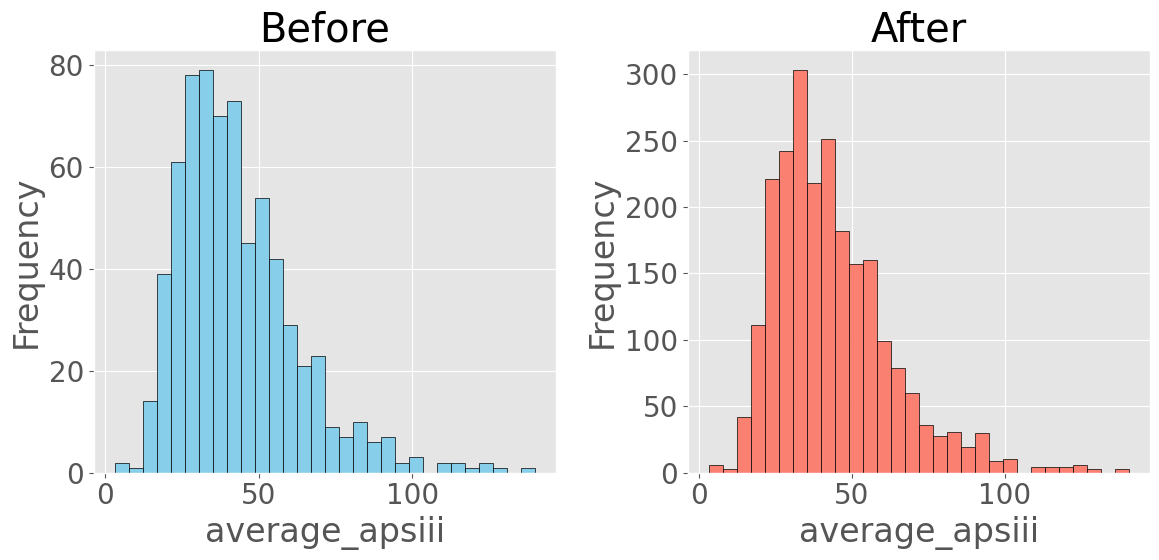

Summary Statistics Before Replacement for average_apsiii:
count    684.000000
mean      43.011318
std       19.703947
min        3.000000
25%       29.000000
50%       39.000000
75%       53.000000
max      140.000000
Name: average_apsiii, dtype: float64

Summary Statistics After Replacement for average_apsiii:
count    2321.000000
mean       43.447644
std        19.432240
min         3.000000
25%        29.604902
50%        40.000000
75%        53.646078
max       140.764257
Name: average_apsiii, dtype: float64




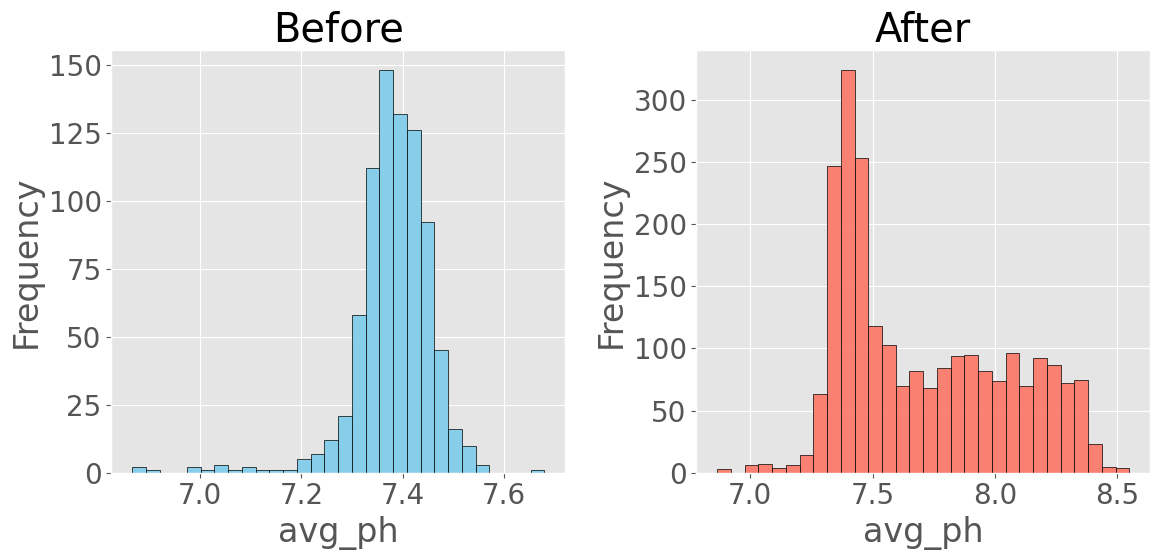

Summary Statistics Before Replacement for avg_ph:
count    803.000000
mean       7.381606
std        0.076856
min        6.865000
25%        7.348284
50%        7.386957
75%        7.430000
max        7.680000
Name: avg_ph, dtype: float64

Summary Statistics After Replacement for avg_ph:
count    2321.000000
mean        7.708698
std         0.343204
min         6.865000
25%         7.410000
50%         7.606826
75%         8.002453
max         8.549198
Name: avg_ph, dtype: float64




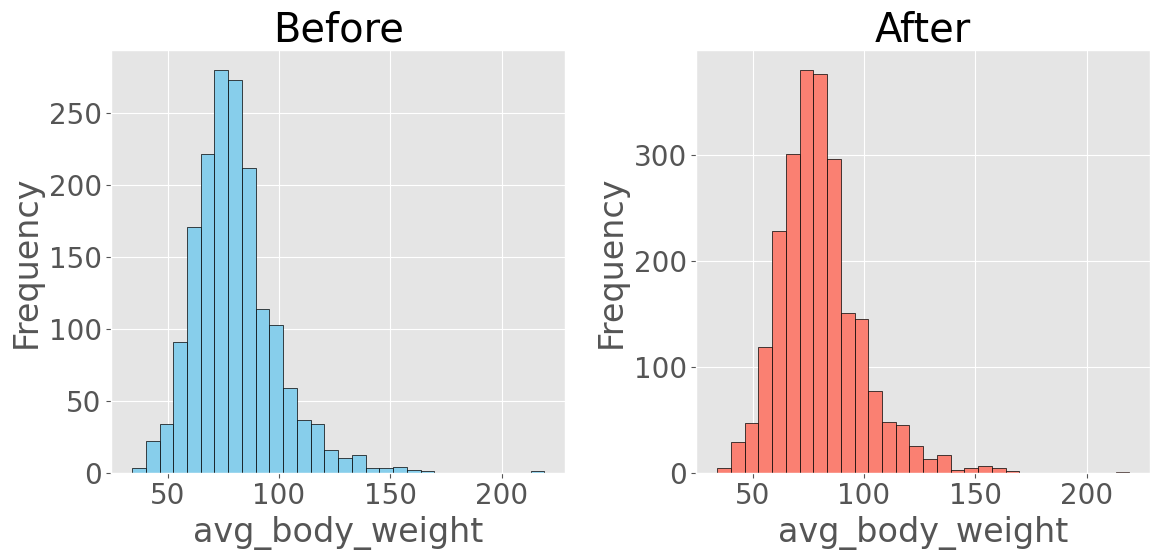

Summary Statistics Before Replacement for avg_body_weight:
count    1707.000000
mean       80.077497
std        18.413644
min        34.019400
25%        68.038800
50%        78.076413
75%        88.696136
max       219.156550
Name: avg_body_weight, dtype: float64

Summary Statistics After Replacement for avg_body_weight:
count    2321.000000
mean       80.225479
std        18.458081
min        34.019400
25%        68.135998
50%        78.221940
75%        88.731100
max       219.156550
Name: avg_body_weight, dtype: float64




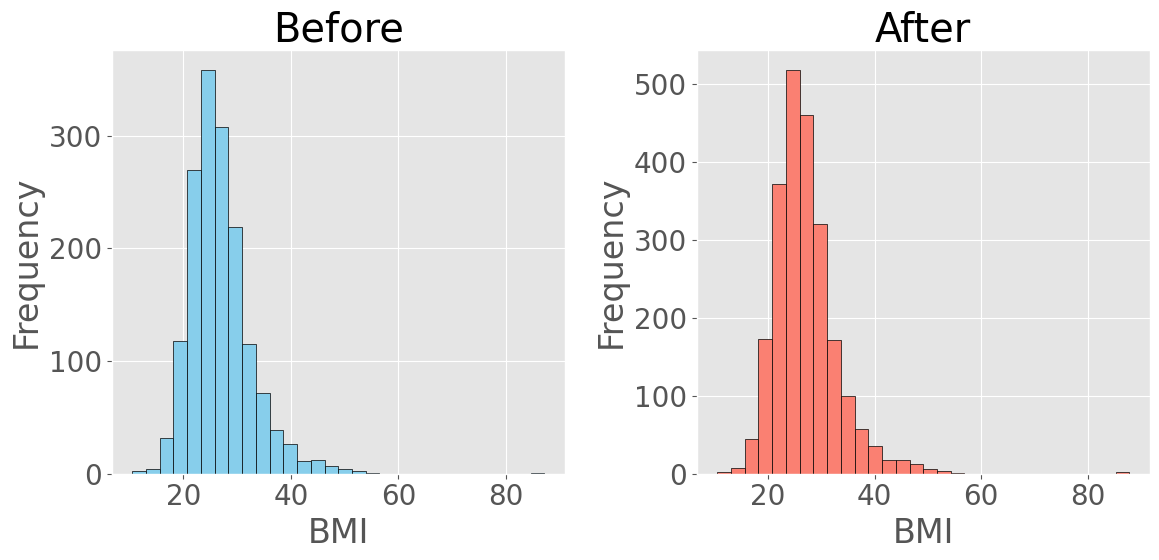

Summary Statistics Before Replacement for BMI:
count    1600.000000
mean       26.783850
std         5.821533
min        10.450000
25%        23.033333
50%        25.850000
75%        29.485833
max        87.159016
Name: BMI, dtype: float64

Summary Statistics After Replacement for BMI:
count    2321.000000
mean       27.050461
std         5.964557
min        10.450000
25%        23.240000
50%        26.136791
75%        29.720000
max        87.817510
Name: BMI, dtype: float64




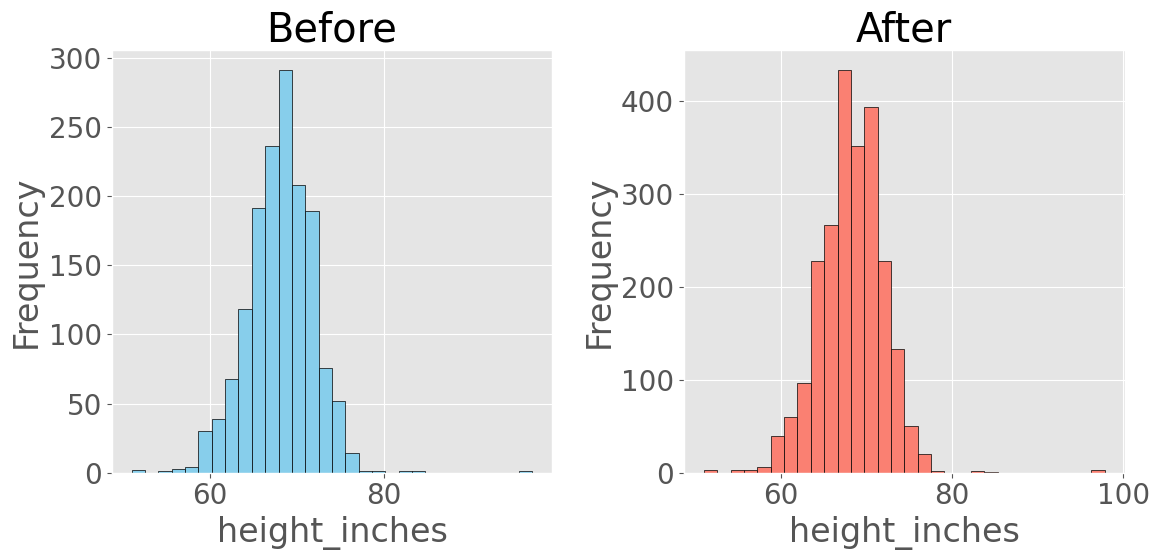

Summary Statistics Before Replacement for height_inches:
count    1527.000000
mean       68.016001
std         3.680169
min        51.000000
25%        66.000000
50%        68.000000
75%        70.309868
max        97.000000
Name: height_inches, dtype: float64

Summary Statistics After Replacement for height_inches:
count    2321.000000
mean       68.248986
std         3.757221
min        51.000000
25%        66.000000
50%        68.313497
75%        70.720756
max        97.815303
Name: height_inches, dtype: float64




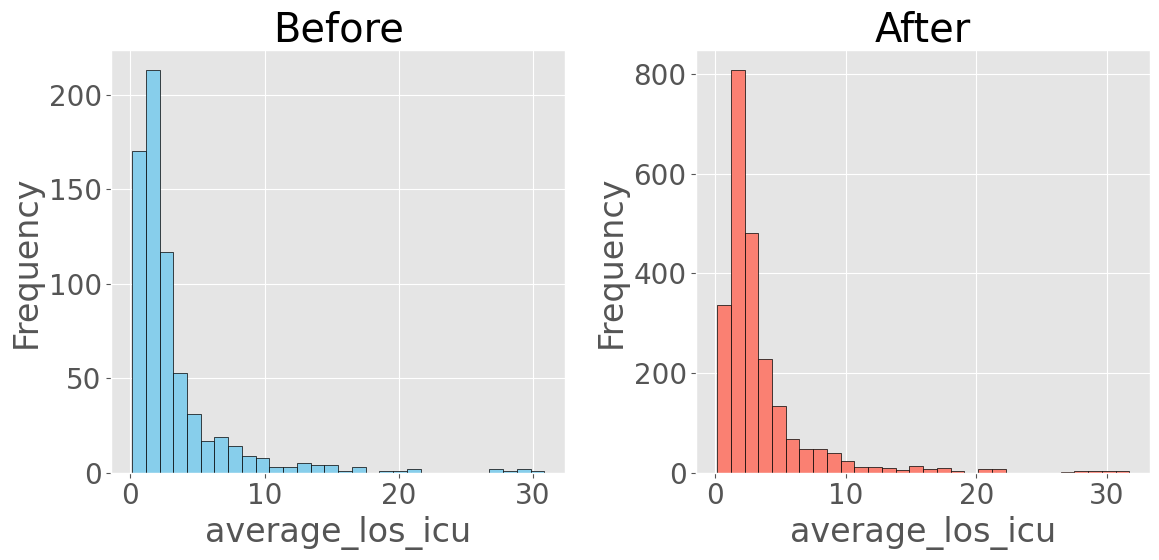

Summary Statistics Before Replacement for average_los_icu:
count    684.000000
mean       3.228011
std        3.969580
min        0.124936
25%        1.160587
50%        1.955029
75%        3.478032
max       30.847350
Name: average_los_icu, dtype: float64

Summary Statistics After Replacement for average_los_icu:
count    2321.000000
mean        3.473938
std         3.879269
min         0.124936
25%         1.479400
50%         2.268467
75%         3.736327
max        31.716304
Name: average_los_icu, dtype: float64




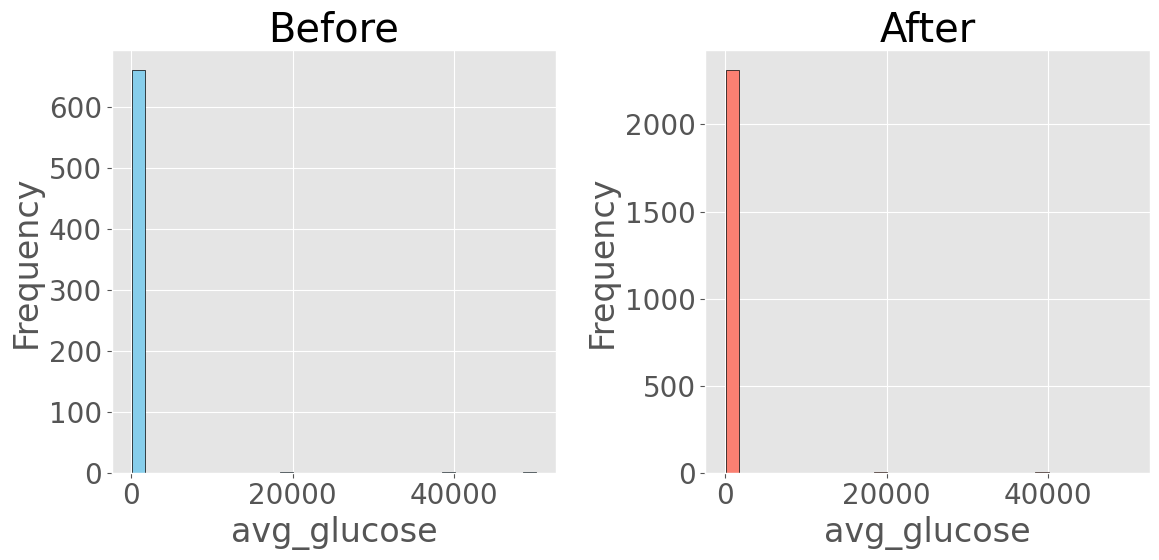

Summary Statistics Before Replacement for avg_glucose:
count      664.000000
mean       298.723439
std       2587.102344
min         71.000000
25%        106.725000
50%        123.330000
75%        149.677885
max      50120.150000
Name: avg_glucose, dtype: float64

Summary Statistics After Replacement for avg_glucose:
count     2321.000000
mean       274.834153
std       2345.035082
min         71.000000
25%        106.573104
50%        122.592170
75%        148.741780
max      50120.150000
Name: avg_glucose, dtype: float64




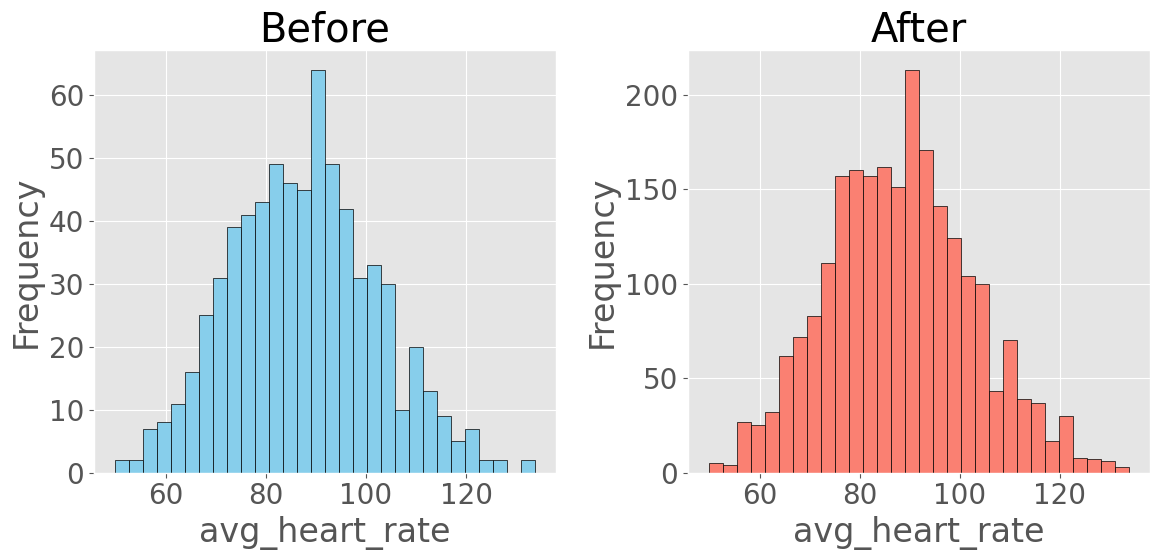

Summary Statistics Before Replacement for avg_heart_rate:
count    684.000000
mean      87.578023
std       14.530096
min       49.753846
25%       77.150121
50%       87.294190
75%       97.091353
max      133.829268
Name: avg_heart_rate, dtype: float64

Summary Statistics After Replacement for avg_heart_rate:
count    2321.000000
mean       88.157681
std        14.554221
min        49.753846
25%        77.867248
50%        87.821429
75%        97.517241
max       133.829268
Name: avg_heart_rate, dtype: float64




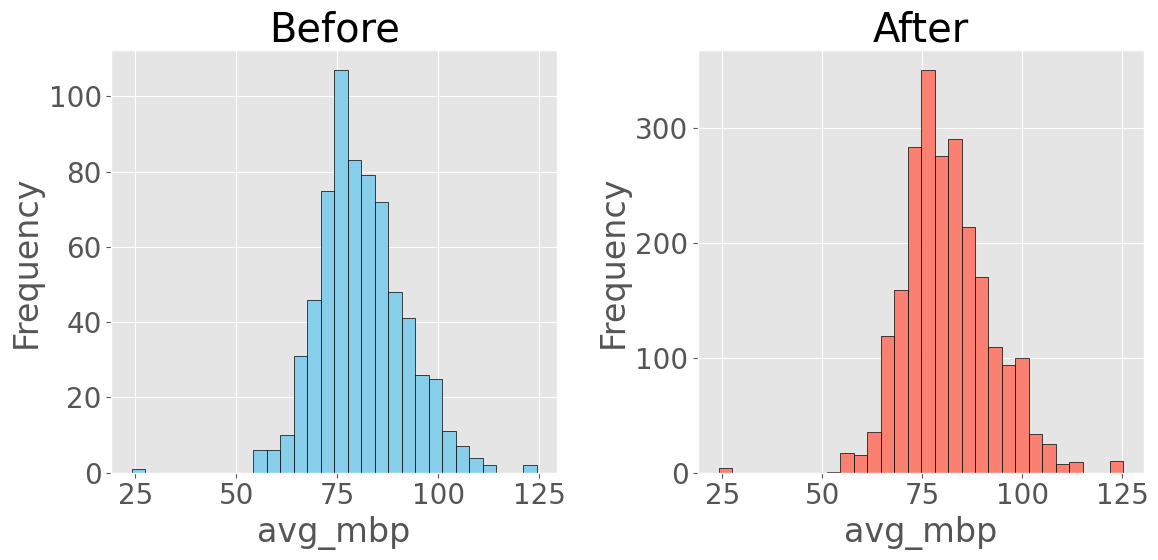

Summary Statistics Before Replacement for avg_mbp:
count    682.000000
mean      80.920450
std       10.741990
min       24.071429
25%       74.021854
50%       79.564326
75%       87.277961
max      124.263158
Name: avg_mbp, dtype: float64

Summary Statistics After Replacement for avg_mbp:
count    2321.000000
mean       81.371416
std        10.959876
min        24.071429
25%        74.258065
50%        80.100451
75%        87.470590
max       125.240727
Name: avg_mbp, dtype: float64




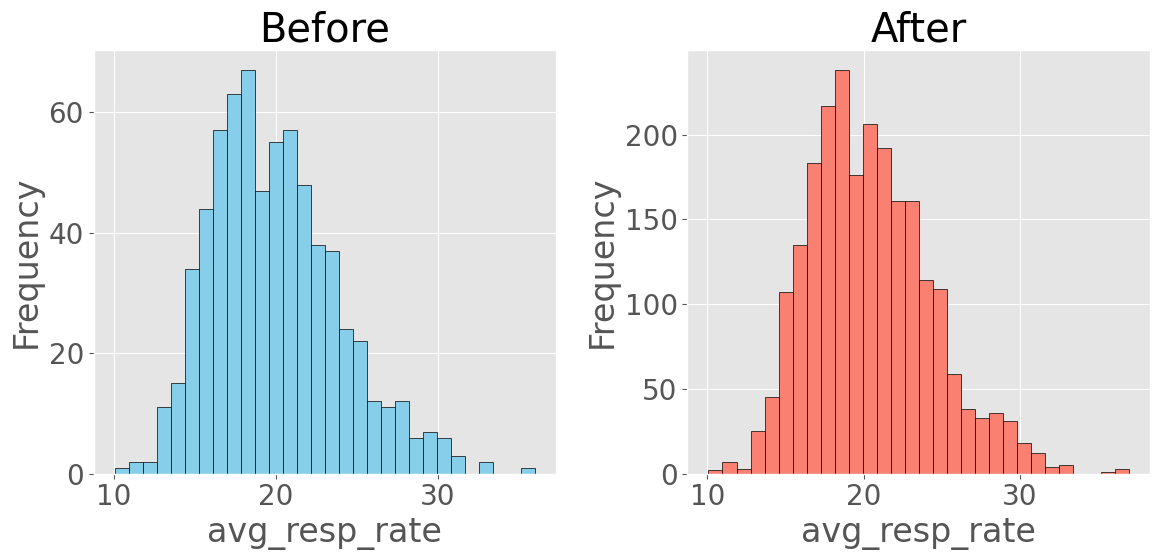

Summary Statistics Before Replacement for avg_resp_rate:
count    684.000000
mean      19.991388
std        3.952828
min       10.066667
25%       17.095548
50%       19.557778
75%       22.331985
max       36.000000
Name: avg_resp_rate, dtype: float64

Summary Statistics After Replacement for avg_resp_rate:
count    2321.000000
mean       20.396566
std         3.893483
min        10.066667
25%        17.598485
50%        20.026086
75%        22.819050
max        36.964626
Name: avg_resp_rate, dtype: float64




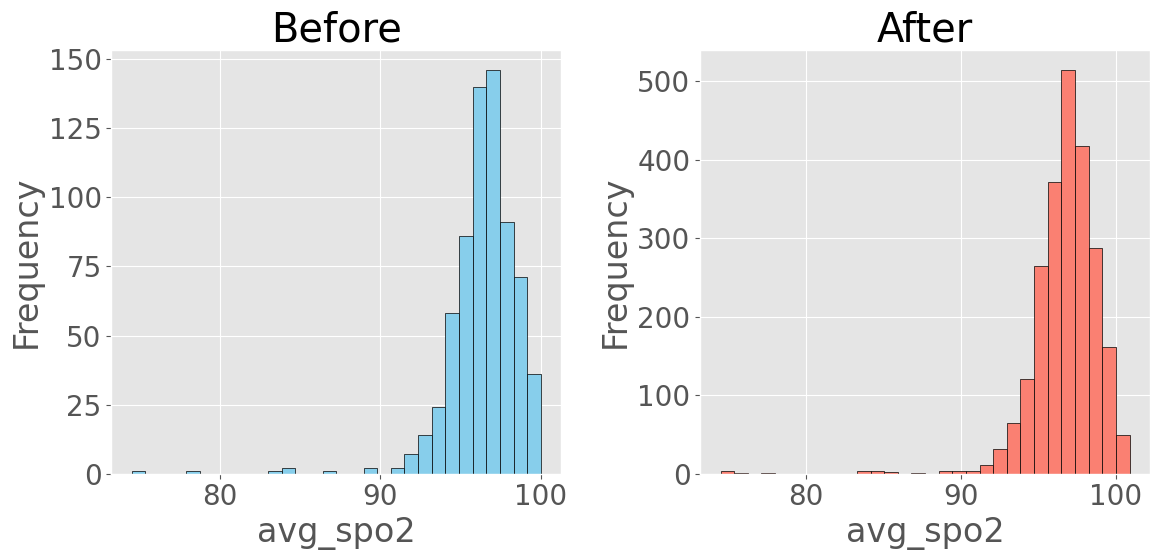

Summary Statistics Before Replacement for avg_spo2:
count    683.000000
mean      96.413148
std        2.215744
min       74.500000
25%       95.473137
50%       96.609626
75%       97.674056
max      100.000000
Name: avg_spo2, dtype: float64

Summary Statistics After Replacement for avg_spo2:
count    2321.000000
mean       96.773839
std         2.214306
min        74.500000
25%        95.801314
50%        96.981452
75%        98.051115
max       100.906652
Name: avg_spo2, dtype: float64




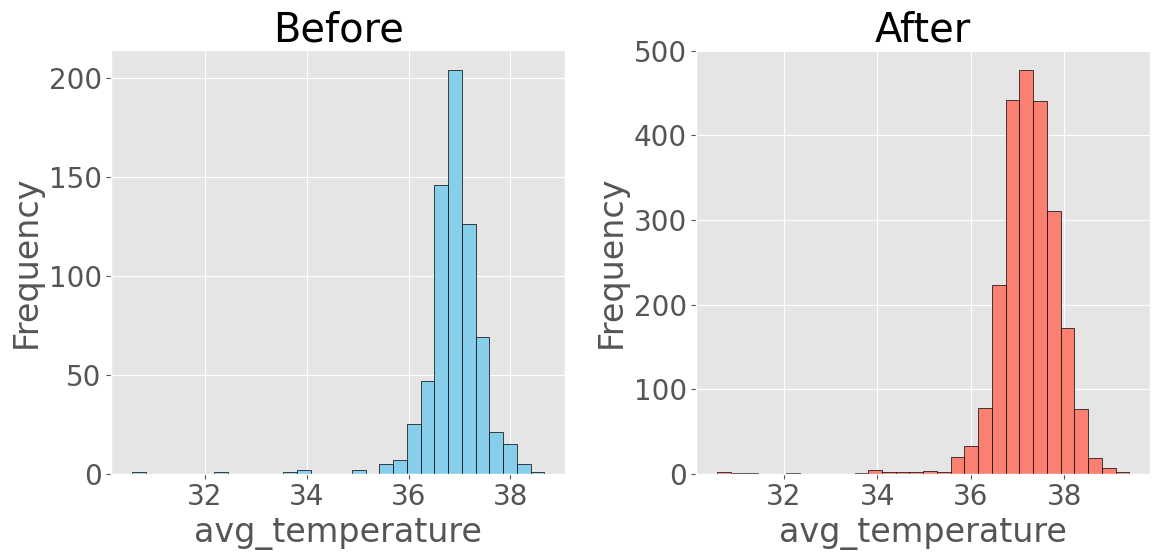

Summary Statistics Before Replacement for avg_temperature:
count              678
unique             653
top       37.055000000
freq                 3
Name: avg_temperature, dtype: object

Summary Statistics After Replacement for avg_temperature:
count             2321
unique            2296
top       36.863333333
freq                 3
Name: avg_temperature, dtype: object




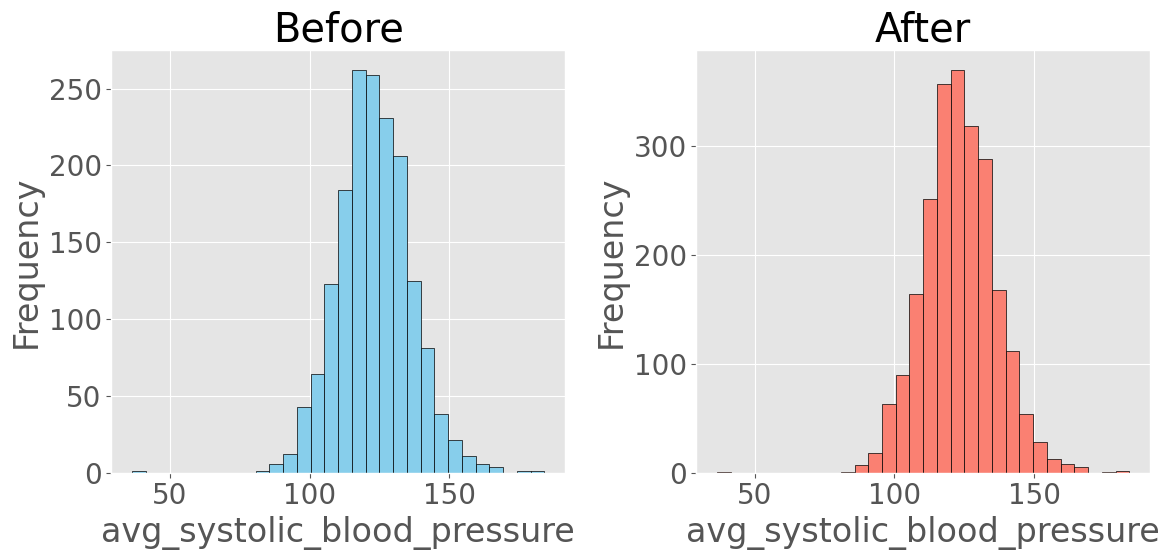

Summary Statistics Before Replacement for avg_systolic_blood_pressure:
count    1680.000000
mean      123.292259
std        13.045014
min        36.500000
25%       115.000000
50%       122.793806
75%       131.952232
max       184.000000
Name: avg_systolic_blood_pressure, dtype: float64

Summary Statistics After Replacement for avg_systolic_blood_pressure:
count    2321.000000
mean      123.310498
std        12.962864
min        36.500000
25%       115.000000
50%       122.818182
75%       131.727273
max       184.088480
Name: avg_systolic_blood_pressure, dtype: float64




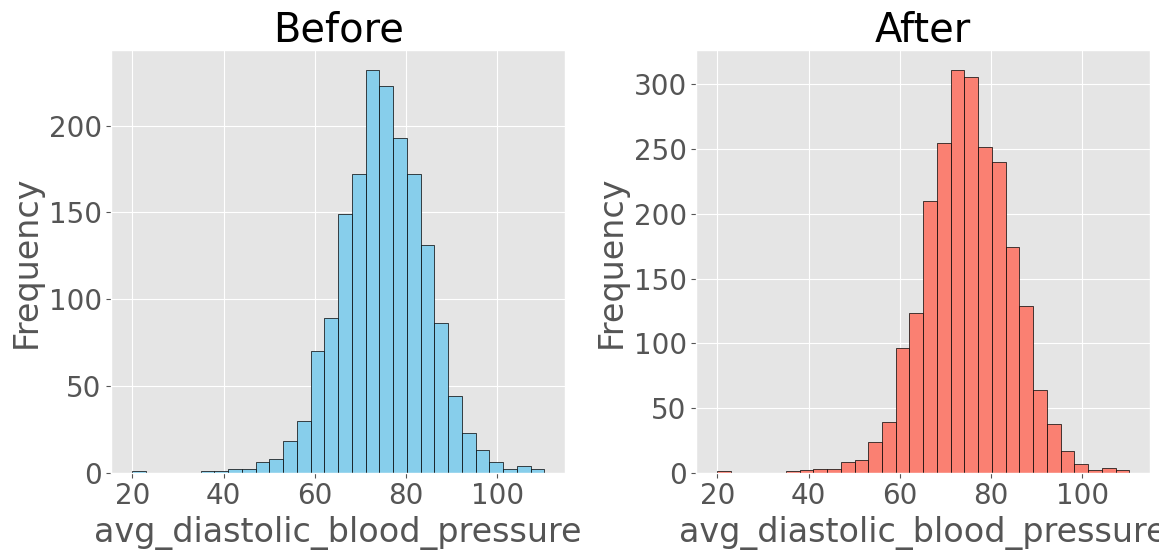

Summary Statistics Before Replacement for avg_diastolic_blood_pressure:
count    1680.000000
mean       75.017820
std         9.444998
min        19.928571
25%        69.000000
50%        75.000000
75%        81.274237
max       110.333333
Name: avg_diastolic_blood_pressure, dtype: float64

Summary Statistics After Replacement for avg_diastolic_blood_pressure:
count    2321.000000
mean       75.023205
std         9.404211
min        19.928571
25%        68.933029
50%        74.833333
75%        81.451531
max       110.333333
Name: avg_diastolic_blood_pressure, dtype: float64




In [305]:
from decimal import Decimal

# List of columns to process
columns = [
    'average_apsiii', 'avg_ph', 'avg_body_weight', 'BMI', 'height_inches',
    'average_los_icu', 'avg_glucose', 'avg_heart_rate', 'avg_mbp',
    'avg_resp_rate', 'avg_spo2', 'avg_temperature',
    'avg_systolic_blood_pressure', 'avg_diastolic_blood_pressure'
]

# Loop through each column and perform NaN replacement, plotting, and statistical comparison
for column in columns:
    # Step 1: Get a copy of the column before replacement
    column_before = filtered_df[column].copy()

    # Step 2: Get non-null values for filling NaNs
    non_null_values = column_before.dropna()

    # Step 3: Fill NaN values in-place with sampled values + random noise converted to Decimal
    filtered_df[column] = filtered_df[column].apply(
        lambda x: float(np.random.choice(non_null_values)) + np.random.uniform(0.000001, 1) if pd.isna(x) else x
    )

    # Step 4: Plot histograms for before and after replacement
    plt.figure(figsize=(12, 6))

    # Histogram before replacement
    plt.subplot(1, 2, 1)
    plt.hist(column_before.dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Before')
    plt.xlabel(column)
    plt.ylabel('Frequency')


    plt.subplot(1, 2, 2)
    plt.hist(filtered_df[column], bins=30, color='salmon', edgecolor='black')
    plt.title(f'After')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Step 5: Print summary statistics
    print(f"Summary Statistics Before Replacement for {column}:")
    print(column_before.describe())

    print(f"\nSummary Statistics After Replacement for {column}:")
    print(filtered_df[column].describe())
    print("\n" + "="*50 + "\n")

In [306]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2321 non-null   Int64  
 1   race                            2321 non-null   int64  
 2   marital_status                  2321 non-null   int64  
 3   age                             2321 non-null   Int64  
 4   average_apsiii                  2321 non-null   float64
 5   avg_charlson_comorbidity_index  2321 non-null   float64
 6   gender                          2321 non-null   int64  
 7   dod                             2321 non-null   int64  
 8   avg_ph                          2321 non-null   float64
 9   avg_body_weight                 2321 non-null   float64
 10  BMI                             2321 non-null   float64
 11  height_inches                   2321 non-null   float64
 12  average_los_icu                 23

In [307]:
file_path = 'generic_features_for_positive_patient.csv'

# Save the DataFrame to a CSV file
filtered_df.to_csv(file_path, index=False)  # Set index=False to avoid writing row indices

In [330]:
random_df = run_query("""
WITH earliest_admissions AS (
    SELECT subject_id, MIN(admittime) AS earliest_admittime
    FROM physionet-data.mimiciv_hosp.admissions
    GROUP BY subject_id
),
age_data AS (
    SELECT d.subject_id, MIN(a.age) AS age
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.age a ON d.subject_id = a.subject_id
    GROUP BY d.subject_id
),
apsiii_data AS (
    SELECT d.subject_id, AVG(a.apsiii) AS average_apsiii
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.apsiii a ON d.subject_id = a.subject_id
    GROUP BY d.subject_id
),
charlson_data AS (
    SELECT d.subject_id, AVG(c.charlson_comorbidity_index) AS avg_charlson_comorbidity_index
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.charlson c ON d.subject_id = c.subject_id
    GROUP BY d.subject_id
),
gender_data AS (
    SELECT DISTINCT d.subject_id, p.gender
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_hosp.patients p ON d.subject_id = p.subject_id
),
dod_data AS (
    SELECT DISTINCT d.subject_id, p.dod
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_hosp.patients p ON d.subject_id = p.subject_id
),
ph_data AS (
    SELECT d.subject_id, AVG(bg.ph) AS avg_ph
    FROM physionet-data.mimiciv_hosp.diagnoses_icd d
    JOIN physionet-data.mimiciv_derived.bg bg ON d.subject_id = bg.subject_id
    GROUP BY d.subject_id
),
weight_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(omr.result_value AS FLOAT64) * 0.453592) AS avg_body_weight
    FROM physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name = 'Weight (Lbs)'
    GROUP BY patients.subject_id
),
bmi_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(omr.result_value AS FLOAT64)) AS BMI
    FROM physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name = 'BMI (kg/m2)'
    GROUP BY patients.subject_id
),
bp_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(SPLIT(omr.result_value, '/')[SAFE_OFFSET(0)] AS FLOAT64)) AS avg_systolic_BP,
        AVG(CAST(SPLIT(omr.result_value, '/')[SAFE_OFFSET(1)] AS FLOAT64)) AS avg_diastolic_BP
    FROM
        physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN
        physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name LIKE 'Blood Pressure%'
    WHERE patients.subject_id IN (SELECT subject_id FROM physionet-data.mimiciv_hosp.diagnoses_icd)
    GROUP BY patients.subject_id
),
height_data AS (
    SELECT
        patients.subject_id,
        AVG(CAST(omr.result_value AS FLOAT64)) AS height_inches
    FROM
        physionet-data.mimiciv_hosp.patients AS patients
    LEFT JOIN
        physionet-data.mimiciv_hosp.omr AS omr
        ON patients.subject_id = omr.subject_id
        AND omr.result_name = 'Height (Inches)'
    WHERE patients.subject_id IN (SELECT subject_id FROM physionet-data.mimiciv_hosp.diagnoses_icd)
    GROUP BY patients.subject_id
),
los_data AS (
    SELECT
        icu.subject_id,
        AVG(icu.los) AS average_los_icu
    FROM
        physionet-data.mimiciv_icu.icustays icu
    WHERE icu.subject_id IN (SELECT subject_id FROM physionet-data.mimiciv_hosp.diagnoses_icd)
    GROUP BY icu.subject_id
),
vitalsign_data AS (
    SELECT
        v.subject_id,
        AVG(v.dbp) AS avg_dbp,
        AVG(v.glucose) AS avg_glucose,
        AVG(v.heart_rate) AS avg_heart_rate,
        AVG(v.mbp) AS avg_mbp,
        AVG(v.resp_rate) AS avg_resp_rate,
        AVG(v.sbp) AS avg_sbp,
        AVG(v.spo2) AS avg_spo2,
        AVG(v.temperature) AS avg_temperature
    FROM physionet-data.mimiciv_derived.vitalsign v
    WHERE v.subject_id IN (SELECT subject_id FROM physionet-data.mimiciv_hosp.diagnoses_icd)
    GROUP BY v.subject_id
),
excluded_subject_ids AS (
    SELECT DISTINCT subject_id
    FROM physionet-data.mimiciv_hosp.diagnoses_icd
    WHERE (icd_code LIKE '042' AND icd_version = 9) OR
          (icd_code LIKE 'B20' AND icd_version = 10) OR
          (icd_code LIKE '07953' AND icd_version = 9) OR
          (icd_code LIKE 'V08' AND icd_version = 9) OR
          (icd_code LIKE 'Z21' AND icd_version = 10)
)

SELECT
    a.subject_id,
    a.race,
    a.marital_status,
    age_data.age,
    apsiii_data.average_apsiii,
    charlson_data.avg_charlson_comorbidity_index,
    gender_data.gender,
    dod_data.dod,
    ph_data.avg_ph,
    weight_data.avg_body_weight,
    bmi_data.BMI,
    bp_data.avg_systolic_BP,
    bp_data.avg_diastolic_BP,
    height_data.height_inches,
    los_data.average_los_icu,
    vitalsign_data.avg_dbp,
    vitalsign_data.avg_glucose,
    vitalsign_data.avg_heart_rate,
    vitalsign_data.avg_mbp,
    vitalsign_data.avg_resp_rate,
    vitalsign_data.avg_sbp,
    vitalsign_data.avg_spo2,
    vitalsign_data.avg_temperature,
    -- Count of non-null values for the specified columns
    (CASE WHEN a.race IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN a.marital_status IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN age_data.age IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN apsiii_data.average_apsiii IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN charlson_data.avg_charlson_comorbidity_index IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN gender_data.gender IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN dod_data.dod IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN ph_data.avg_ph IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN weight_data.avg_body_weight IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN bmi_data.BMI IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN bp_data.avg_systolic_BP IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN bp_data.avg_diastolic_BP IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN height_data.height_inches IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN los_data.average_los_icu IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_dbp IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_glucose IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_heart_rate IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_mbp IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_resp_rate IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_sbp IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_spo2 IS NOT NULL THEN 1 ELSE 0 END +
     CASE WHEN vitalsign_data.avg_temperature IS NOT NULL THEN 1 ELSE 0 END) AS non_null_count
FROM physionet-data.mimiciv_hosp.admissions a
JOIN earliest_admissions e ON a.subject_id = e.subject_id
LEFT JOIN age_data ON a.subject_id = age_data.subject_id
LEFT JOIN apsiii_data ON a.subject_id = apsiii_data.subject_id
LEFT JOIN charlson_data ON a.subject_id = charlson_data.subject_id
LEFT JOIN gender_data ON a.subject_id = gender_data.subject_id
LEFT JOIN dod_data ON a.subject_id = dod_data.subject_id
LEFT JOIN ph_data ON a.subject_id = ph_data.subject_id
LEFT JOIN weight_data ON a.subject_id = weight_data.subject_id
LEFT JOIN bmi_data ON a.subject_id = bmi_data.subject_id
LEFT JOIN bp_data ON a.subject_id = bp_data.subject_id
LEFT JOIN height_data ON a.subject_id = height_data.subject_id
LEFT JOIN los_data ON a.subject_id = los_data.subject_id
LEFT JOIN vitalsign_data ON a.subject_id = vitalsign_data.subject_id
WHERE a.subject_id NOT IN (SELECT subject_id FROM excluded_subject_ids)
ORDER BY RAND()
LIMIT 10000;
""")

<ipython-input-3-6f5fba12c048>:9: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


In [331]:
random_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,avg_systolic_BP,avg_diastolic_BP,height_inches,average_los_icu,avg_dbp,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_sbp,avg_spo2,avg_temperature,non_null_count
0,17613076,BLACK/AFRICAN AMERICAN,SINGLE,58,NaN,3.000000,F,NaT,NaN,110.013690,48.900000,132.921348,86.000000,58.869048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10
1,13141043,WHITE,MARRIED,46,37.333333,3.285714,F,NaT,7.312857,108.853575,39.893750,130.000000,71.954545,65.250000,2.361308,67.219653,194.584906,104.863636,79.757225,26.210983,118.890173,95.508475,37.056600000,21
2,15837207,WHITE,WIDOWED,74,30.500000,4.800000,M,NaT,7.360476,71.500463,24.683333,123.666667,68.666667,67.000000,2.360509,53.398437,127.190476,94.587302,67.406250,21.011628,108.531250,96.524194,37.106600000,21
3,10840486,OTHER,SINGLE,25,NaN,0.000000,F,NaT,NaN,83.755763,34.000000,106.600000,69.200000,62.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10
4,19136616,WHITE,SINGLE,60,NaN,1.000000,M,NaT,NaN,84.685626,NaN,164.800000,98.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19822093,WHITE,SINGLE,53,60.000000,6.437500,M,2150-12-29,7.412778,82.652778,23.760000,108.818182,64.909091,72.000000,3.200972,72.875410,172.828402,90.749196,87.651316,20.964630,136.222951,96.977492,37.150465116,22
9996,18136887,WHITE,MARRIED,49,35.000000,1.000000,F,NaT,7.308571,64.405278,24.145238,130.082645,81.900826,64.084048,1.299537,66.057143,138.000000,87.371429,76.424242,19.685714,104.714286,97.676471,36.555555556,21
9997,16185428,WHITE,MARRIED,60,31.000000,4.200000,M,NaT,7.394211,125.240078,38.263333,145.907692,88.369231,71.166667,3.672650,79.358209,169.640000,79.804688,101.843284,20.128000,145.813433,95.272727,36.903846154,21
9998,11976424,WHITE,SINGLE,78,NaN,3.666667,F,NaT,NaN,70.896430,28.100000,130.285714,81.142857,62.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10


In [332]:
filtered_df = random_df[random_df['non_null_count'] > 20]
print(filtered_df.shape)

(2523, 24)


In [333]:
filtered_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,avg_systolic_BP,avg_diastolic_BP,height_inches,average_los_icu,avg_dbp,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_sbp,avg_spo2,avg_temperature,non_null_count
1,13141043,WHITE,MARRIED,46,37.333333,3.285714,F,NaT,7.312857,108.853575,39.893750,130.000000,71.954545,65.250000,2.361308,67.219653,194.584906,104.863636,79.757225,26.210983,118.890173,95.508475,37.056600000,21
2,15837207,WHITE,WIDOWED,74,30.500000,4.800000,M,NaT,7.360476,71.500463,24.683333,123.666667,68.666667,67.000000,2.360509,53.398437,127.190476,94.587302,67.406250,21.011628,108.531250,96.524194,37.106600000,21
12,14392547,WHITE,SINGLE,34,35.000000,1.142857,M,NaT,7.287500,80.606322,26.041667,128.666667,75.555556,69.000000,6.486377,56.802632,125.888889,72.512658,70.263158,19.767296,115.493421,95.480263,37.126739130,21
13,18066863,WHITE,WIDOWED,89,35.500000,5.666667,F,NaT,7.414000,87.860770,29.450000,139.500000,62.500000,68.000000,1.827031,51.115789,119.200000,69.000000,70.852632,18.390000,119.231579,95.765306,36.922800000,21
18,19692222,WHITE,MARRIED,56,41.333333,6.538462,M,2197-05-02,7.455833,102.732773,32.671429,129.604651,80.720930,67.250000,5.541179,77.763529,147.295620,85.066587,97.117647,18.290888,141.978235,96.912260,37.325298507,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,16257560,WHITE,SINGLE,73,48.454545,7.241379,M,2143-01-25,7.302609,79.718794,27.325000,107.500000,61.964286,67.500000,2.922511,53.623077,118.822581,80.547816,68.132952,21.849348,109.553846,97.379135,36.322950000,22
9995,19822093,WHITE,SINGLE,53,60.000000,6.437500,M,2150-12-29,7.412778,82.652778,23.760000,108.818182,64.909091,72.000000,3.200972,72.875410,172.828402,90.749196,87.651316,20.964630,136.222951,96.977492,37.150465116,22
9996,18136887,WHITE,MARRIED,49,35.000000,1.000000,F,NaT,7.308571,64.405278,24.145238,130.082645,81.900826,64.084048,1.299537,66.057143,138.000000,87.371429,76.424242,19.685714,104.714286,97.676471,36.555555556,21
9997,16185428,WHITE,MARRIED,60,31.000000,4.200000,M,NaT,7.394211,125.240078,38.263333,145.907692,88.369231,71.166667,3.672650,79.358209,169.640000,79.804688,101.843284,20.128000,145.813433,95.272727,36.903846154,21


In [334]:
filtered_df['avg_systolic_blood_pressure'] = filtered_df.apply(
    lambda row: (row['avg_systolic_BP'] + row['avg_sbp']) / 2 if pd.notna(row['avg_systolic_BP']) and pd.notna(row['avg_sbp'])
    else row['avg_systolic_BP'] if pd.notna(row['avg_systolic_BP'])
    else row['avg_sbp'] if pd.notna(row['avg_sbp'])
    else None, axis=1
)

filtered_df['avg_diastolic_blood_pressure'] = filtered_df.apply(
    lambda row: (row['avg_diastolic_BP'] + row['avg_dbp']) / 2 if pd.notna(row['avg_diastolic_BP']) and pd.notna(row['avg_dbp'])
    else row['avg_diastolic_BP'] if pd.notna(row['avg_diastolic_BP'])
    else row['avg_dbp'] if pd.notna(row['avg_dbp'])
    else None, axis=1
)

# Display the updated DataFrame
print(filtered_df.shape)
filtered_df

(2523, 26)


<ipython-input-334-737a7e5edfbc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['avg_systolic_blood_pressure'] = filtered_df.apply(
<ipython-input-334-737a7e5edfbc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['avg_diastolic_blood_pressure'] = filtered_df.apply(


,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,avg_systolic_BP,avg_diastolic_BP,height_inches,average_los_icu,avg_dbp,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_sbp,avg_spo2,avg_temperature,non_null_count,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
1,13141043,WHITE,MARRIED,46,37.333333,3.285714,F,NaT,7.312857,108.853575,39.893750,130.000000,71.954545,65.250000,2.361308,67.219653,194.584906,104.863636,79.757225,26.210983,118.890173,95.508475,37.056600000,21,124.445087,69.587099
2,15837207,WHITE,WIDOWED,74,30.500000,4.800000,M,NaT,7.360476,71.500463,24.683333,123.666667,68.666667,67.000000,2.360509,53.398437,127.190476,94.587302,67.406250,21.011628,108.531250,96.524194,37.106600000,21,116.098958,61.032552
12,14392547,WHITE,SINGLE,34,35.000000,1.142857,M,NaT,7.287500,80.606322,26.041667,128.666667,75.555556,69.000000,6.486377,56.802632,125.888889,72.512658,70.263158,19.767296,115.493421,95.480263,37.126739130,21,122.080044,66.179094
13,18066863,WHITE,WIDOWED,89,35.500000,5.666667,F,NaT,7.414000,87.860770,29.450000,139.500000,62.500000,68.000000,1.827031,51.115789,119.200000,69.000000,70.852632,18.390000,119.231579,95.765306,36.922800000,21,129.365789,56.807895
18,19692222,WHITE,MARRIED,56,41.333333,6.538462,M,2197-05-02,7.455833,102.732773,32.671429,129.604651,80.720930,67.250000,5.541179,77.763529,147.295620,85.066587,97.117647,18.290888,141.978235,96.912260,37.325298507,22,135.791443,79.242230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,16257560,WHITE,SINGLE,73,48.454545,7.241379,M,2143-01-25,7.302609,79.718794,27.325000,107.500000,61.964286,67.500000,2.922511,53.623077,118.822581,80.547816,68.132952,21.849348,109.553846,97.379135,36.322950000,22,108.526923,57.793681
9995,19822093,WHITE,SINGLE,53,60.000000,6.437500,M,2150-12-29,7.412778,82.652778,23.760000,108.818182,64.909091,72.000000,3.200972,72.875410,172.828402,90.749196,87.651316,20.964630,136.222951,96.977492,37.150465116,22,122.520566,68.892250
9996,18136887,WHITE,MARRIED,49,35.000000,1.000000,F,NaT,7.308571,64.405278,24.145238,130.082645,81.900826,64.084048,1.299537,66.057143,138.000000,87.371429,76.424242,19.685714,104.714286,97.676471,36.555555556,21,117.398465,73.978985
9997,16185428,WHITE,MARRIED,60,31.000000,4.200000,M,NaT,7.394211,125.240078,38.263333,145.907692,88.369231,71.166667,3.672650,79.358209,169.640000,79.804688,101.843284,20.128000,145.813433,95.272727,36.903846154,21,145.860563,83.863720


<ipython-input-335-f1445ef8ccec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(['avg_systolic_BP', 'avg_diastolic_BP', 'avg_dbp', 'avg_sbp','non_null_count'], axis=1, inplace=True)
<ipython-input-335-f1445ef8ccec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dod'] = filtered_df['dod'].notna().astype(int)
<ipython-input-335-f1445ef8ccec>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method 

(2523, 21)


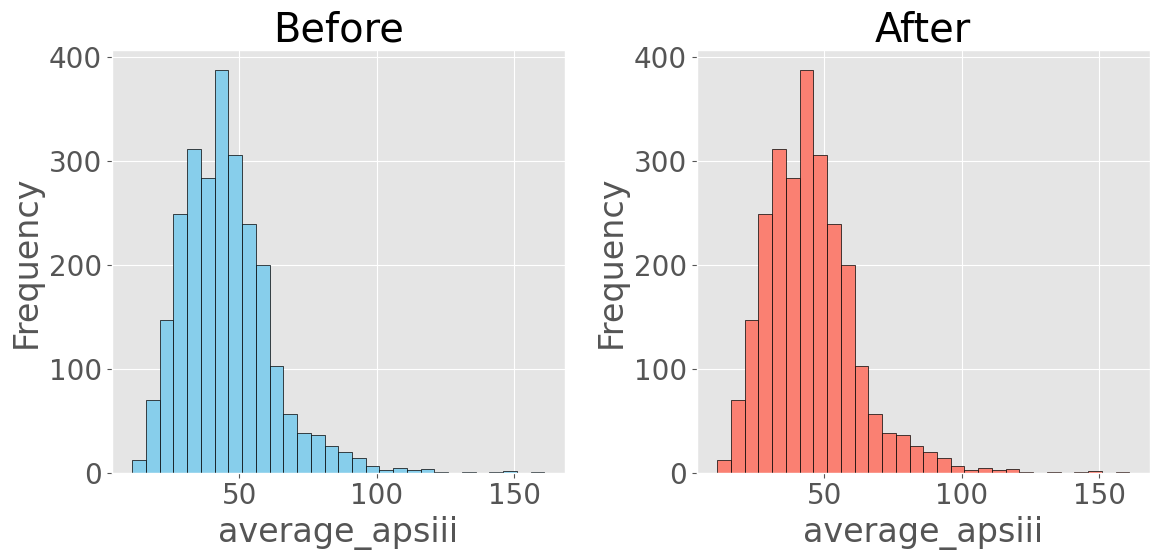

Summary Statistics Before Replacement for average_apsiii:
count    2523.000000
mean       44.833323
std        16.573888
min        11.000000
25%        33.238095
50%        43.000000
75%        53.190909
max       161.000000
Name: average_apsiii, dtype: float64

Summary Statistics After Replacement for average_apsiii:
count    2523.000000
mean       44.833323
std        16.573888
min        11.000000
25%        33.238095
50%        43.000000
75%        53.190909
max       161.000000
Name: average_apsiii, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


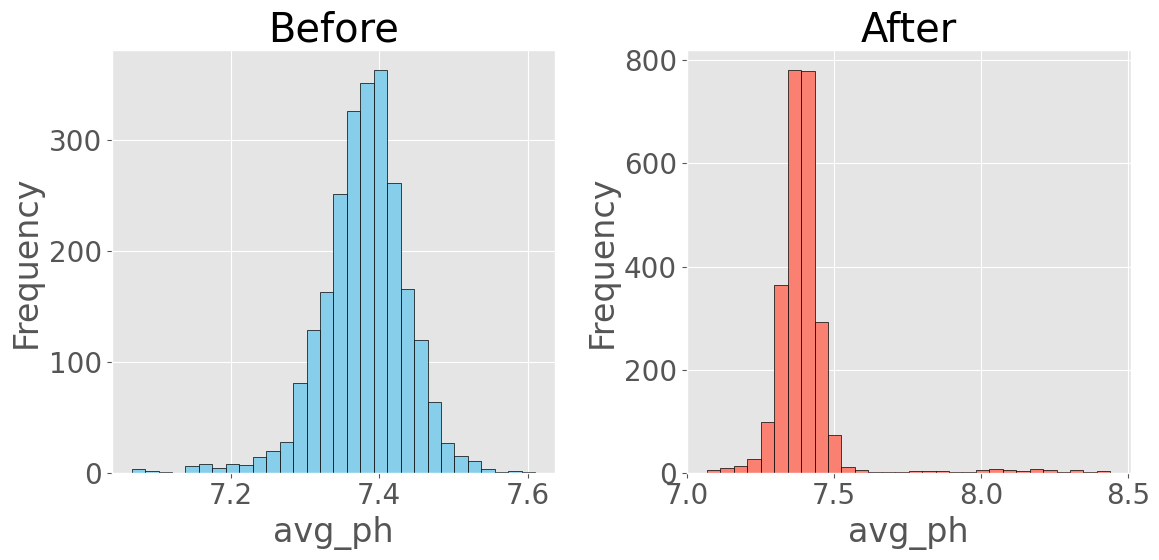

Summary Statistics Before Replacement for avg_ph:
count    2436.000000
mean        7.379928
std         0.057797
min         7.066667
25%         7.348987
50%         7.383246
75%         7.415000
max         7.610000
Name: avg_ph, dtype: float64

Summary Statistics After Replacement for avg_ph:
count    2523.000000
mean        7.398233
std         0.127040
min         7.066667
25%         7.350000
50%         7.385385
75%         7.418889
max         8.440682
Name: avg_ph, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


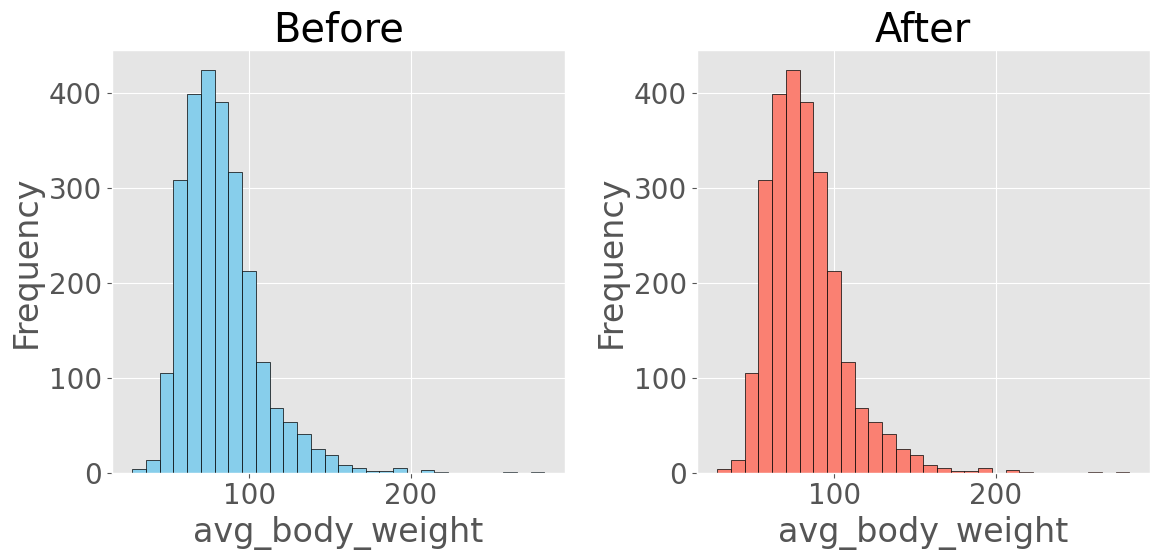

Summary Statistics Before Replacement for avg_body_weight:
count    2523.000000
mean       82.254673
std        23.881456
min        27.376545
25%        66.393583
50%        78.618289
75%        93.447629
max       282.540642
Name: avg_body_weight, dtype: float64

Summary Statistics After Replacement for avg_body_weight:
count    2523.000000
mean       82.254673
std        23.881456
min        27.376545
25%        66.393583
50%        78.618289
75%        93.447629
max       282.540642
Name: avg_body_weight, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


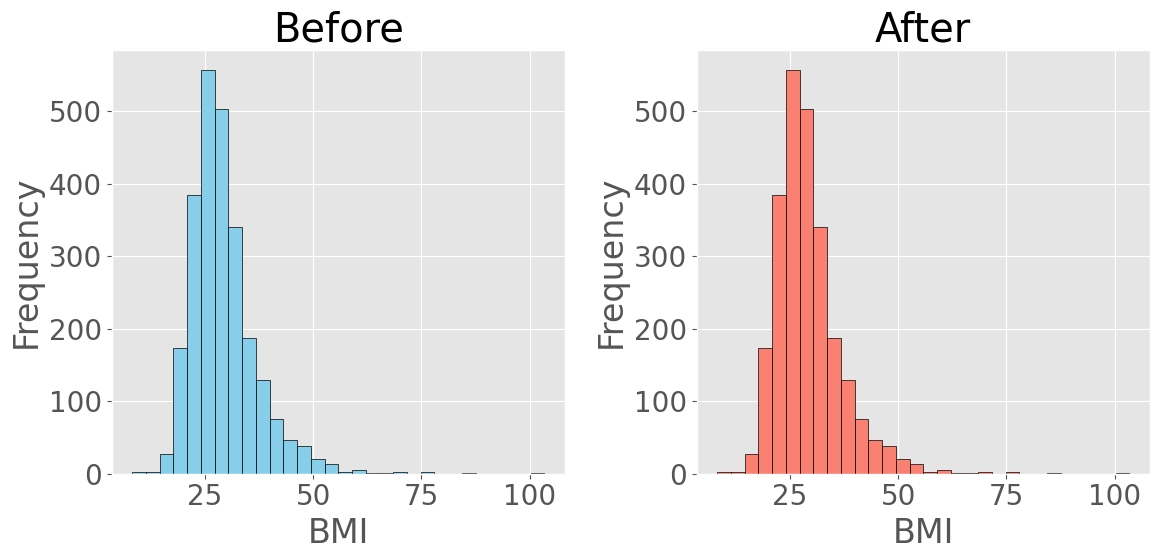

Summary Statistics Before Replacement for BMI:
count    2523.000000
mean       29.286938
std         7.699311
min         8.240000
25%        24.303555
50%        27.827848
75%        32.433333
max       103.375000
Name: BMI, dtype: float64

Summary Statistics After Replacement for BMI:
count    2523.000000
mean       29.286938
std         7.699311
min         8.240000
25%        24.303555
50%        27.827848
75%        32.433333
max       103.375000
Name: BMI, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


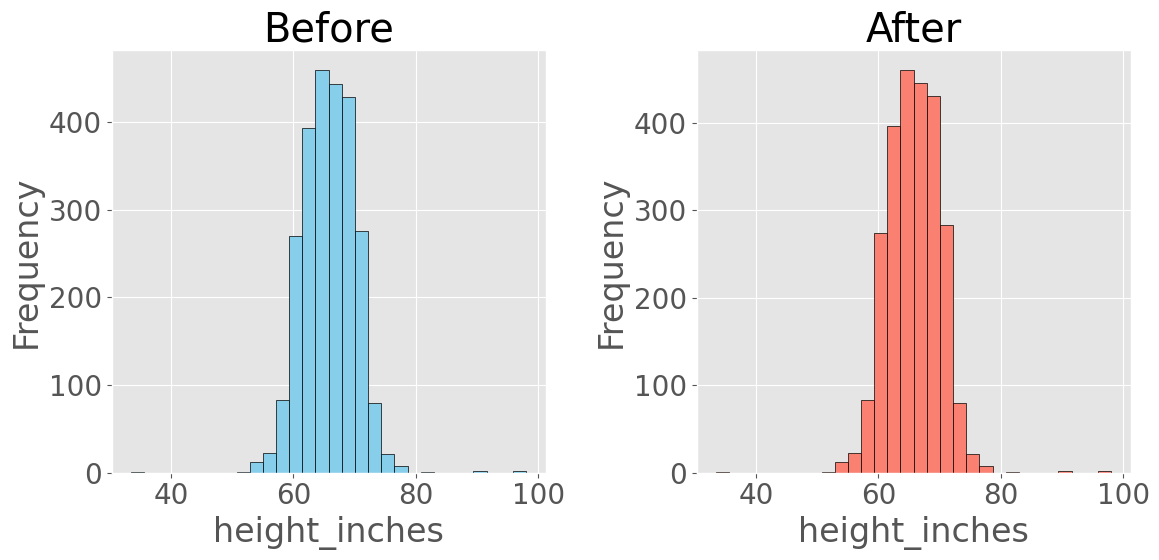

Summary Statistics Before Replacement for height_inches:
count    2502.000000
mean       65.812073
std         4.285327
min        33.500000
25%        62.834559
50%        65.793833
75%        68.874219
max        98.000000
Name: height_inches, dtype: float64

Summary Statistics After Replacement for height_inches:
count    2523.000000
mean       65.813433
std         4.288034
min        33.500000
25%        62.830303
50%        65.800000
75%        68.875000
max        98.000000
Name: height_inches, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


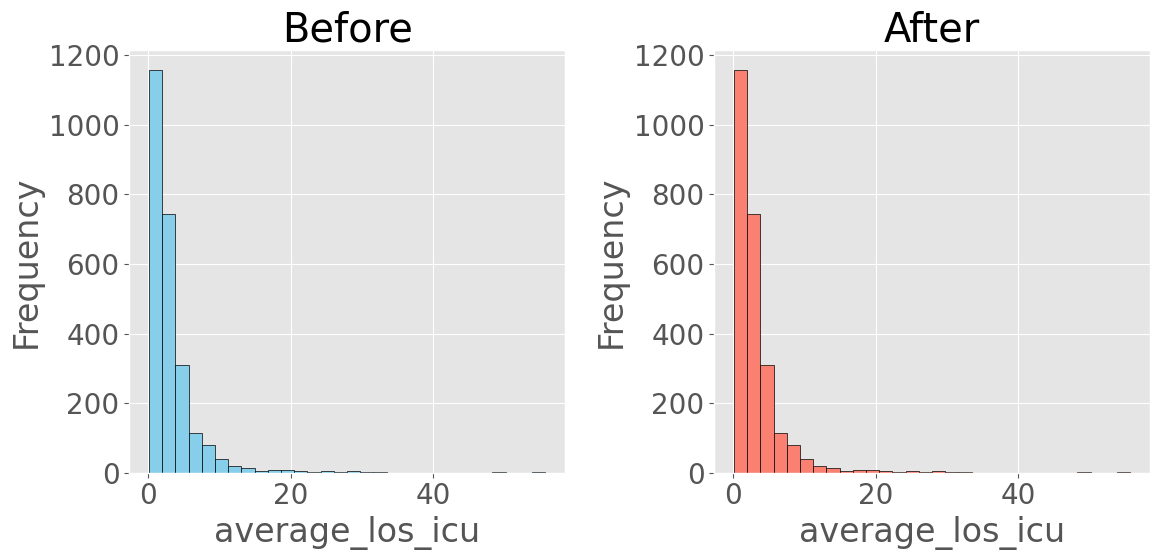

Summary Statistics Before Replacement for average_los_icu:
count    2523.000000
mean        3.278725
std         3.743310
min         0.130810
25%         1.311636
50%         2.150749
75%         3.799032
max        55.720220
Name: average_los_icu, dtype: float64

Summary Statistics After Replacement for average_los_icu:
count    2523.000000
mean        3.278725
std         3.743310
min         0.130810
25%         1.311636
50%         2.150749
75%         3.799032
max        55.720220
Name: average_los_icu, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


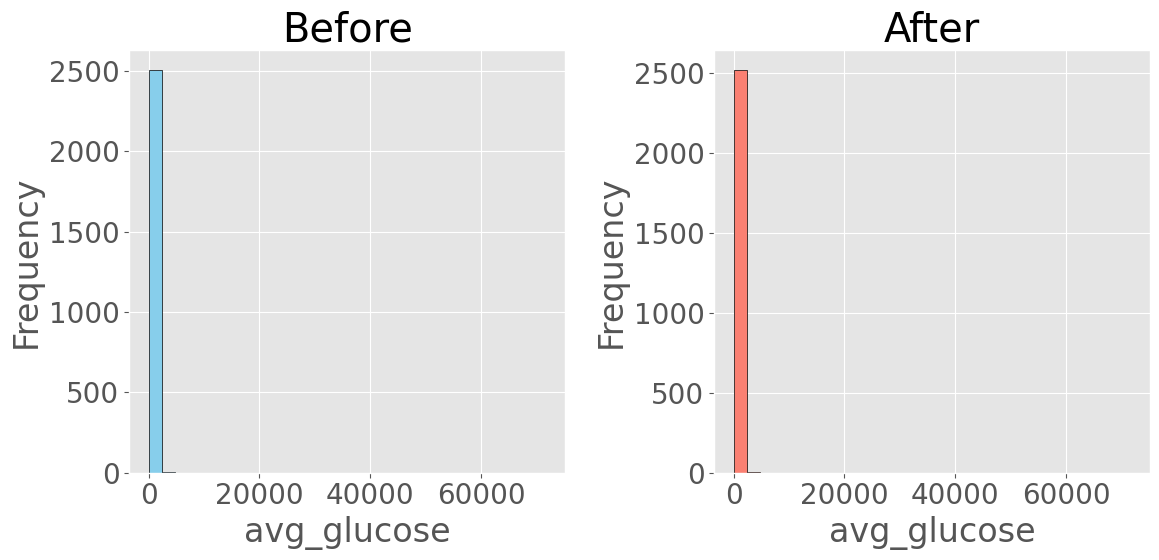

Summary Statistics Before Replacement for avg_glucose:
count     2511.000000
mean       181.819061
std       1435.024740
min         69.000000
25%        116.363053
50%        134.296296
75%        167.825758
max      71534.321429
Name: avg_glucose, dtype: float64

Summary Statistics After Replacement for avg_glucose:
count     2523.000000
mean       181.624303
std       1431.611000
min         69.000000
25%        116.376752
50%        134.400000
75%        167.818182
max      71534.321429
Name: avg_glucose, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


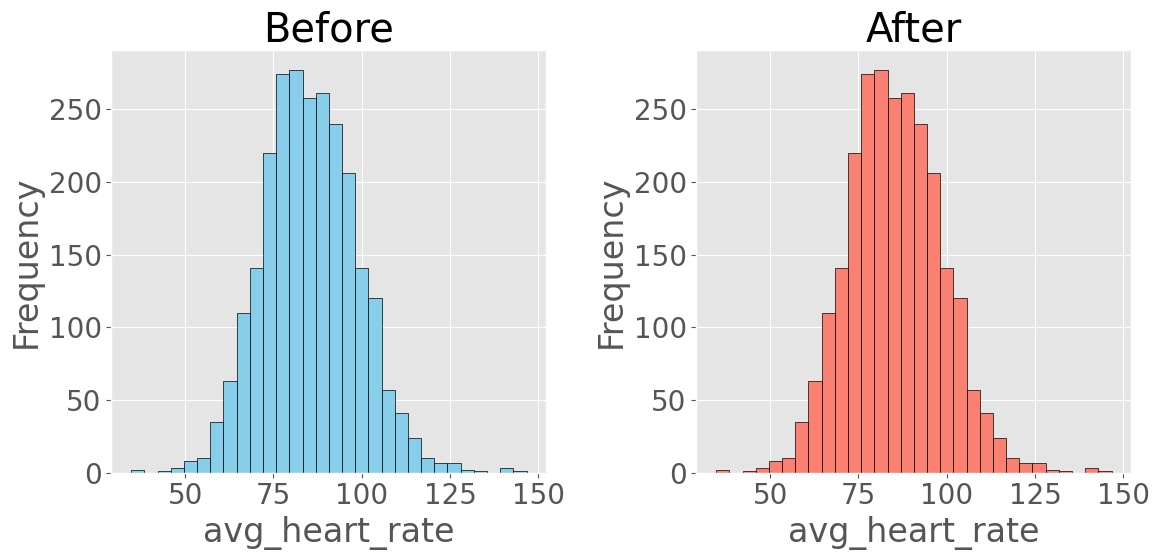

Summary Statistics Before Replacement for avg_heart_rate:
count    2523.000000
mean       85.464965
std        13.311028
min        34.714286
25%        76.318694
50%        84.923409
75%        94.255474
max       146.684211
Name: avg_heart_rate, dtype: float64

Summary Statistics After Replacement for avg_heart_rate:
count    2523.000000
mean       85.464965
std        13.311028
min        34.714286
25%        76.318694
50%        84.923409
75%        94.255474
max       146.684211
Name: avg_heart_rate, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


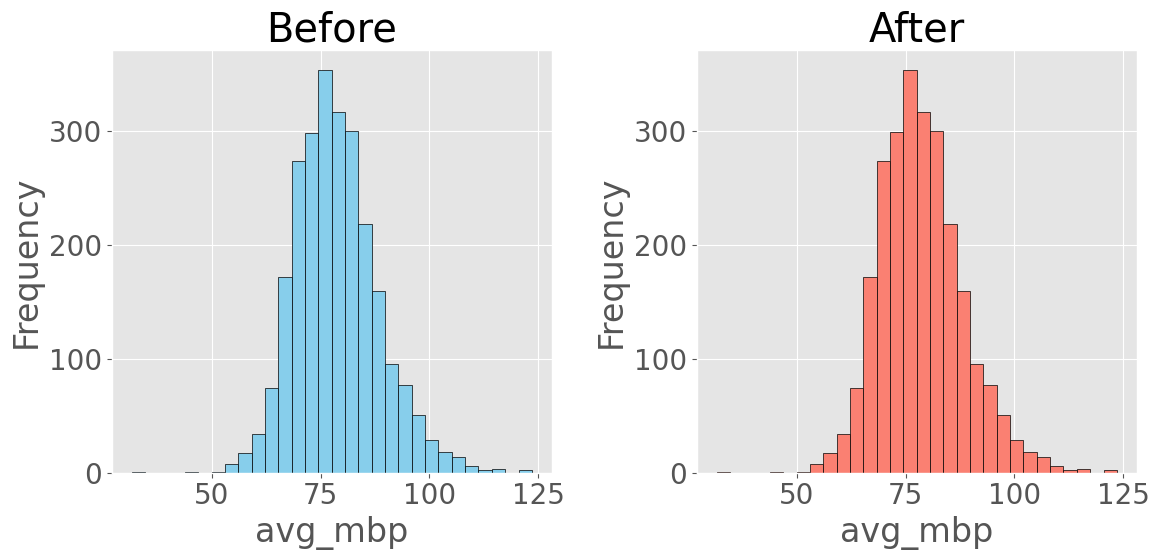

Summary Statistics Before Replacement for avg_mbp:
count    2522.000000
mean       78.657539
std         9.600220
min        31.500000
25%        71.860654
50%        77.833333
75%        84.268182
max       123.589385
Name: avg_mbp, dtype: float64

Summary Statistics After Replacement for avg_mbp:
count    2523.000000
mean       78.654992
std         9.599169
min        31.500000
25%        71.860806
50%        77.833333
75%        84.263636
max       123.589385
Name: avg_mbp, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


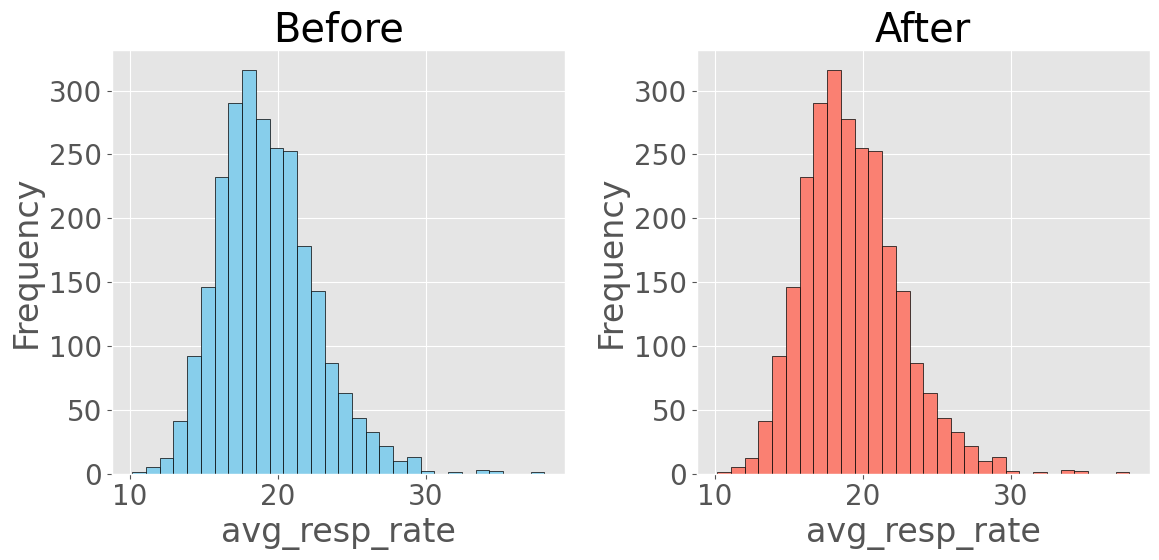

Summary Statistics Before Replacement for avg_resp_rate:
count    2523.000000
mean       19.281677
std         3.220789
min        10.166667
25%        17.000000
50%        18.938095
75%        21.197999
max        38.000000
Name: avg_resp_rate, dtype: float64

Summary Statistics After Replacement for avg_resp_rate:
count    2523.000000
mean       19.281677
std         3.220789
min        10.166667
25%        17.000000
50%        18.938095
75%        21.197999
max        38.000000
Name: avg_resp_rate, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


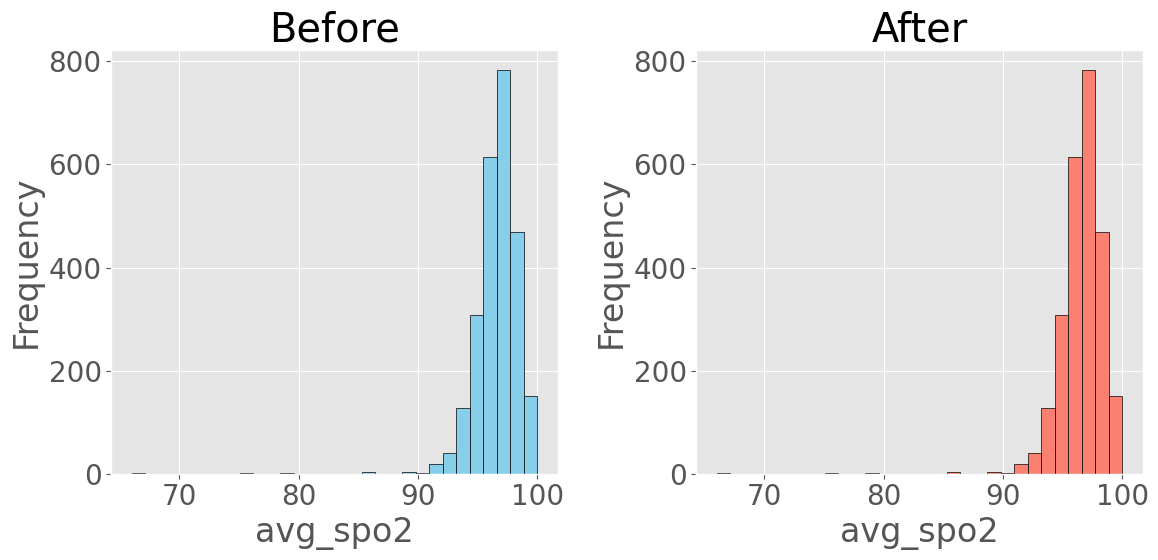

Summary Statistics Before Replacement for avg_spo2:
count    2523.000000
mean       96.613845
std         1.789688
min        66.000000
25%        95.764706
50%        96.792208
75%        97.708027
max       100.000000
Name: avg_spo2, dtype: float64

Summary Statistics After Replacement for avg_spo2:
count    2523.000000
mean       96.613845
std         1.789688
min        66.000000
25%        95.764706
50%        96.792208
75%        97.708027
max       100.000000
Name: avg_spo2, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


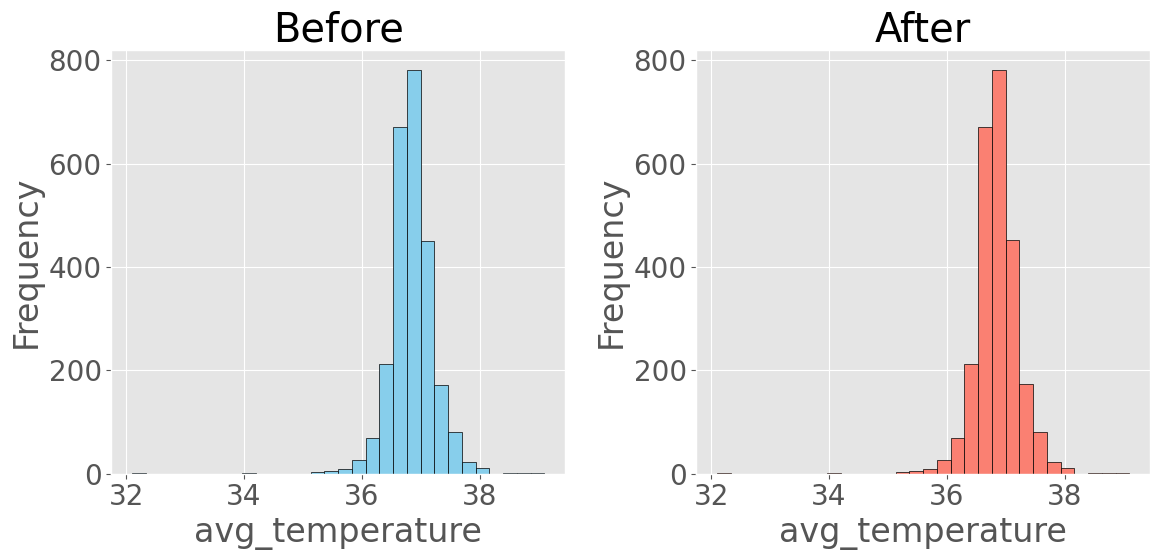

Summary Statistics Before Replacement for avg_temperature:
count             2520
unique            2064
top       36.860000000
freq                 7
Name: avg_temperature, dtype: object

Summary Statistics After Replacement for avg_temperature:
count             2523
unique            2067
top       36.860000000
freq                 7
Name: avg_temperature, dtype: object




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


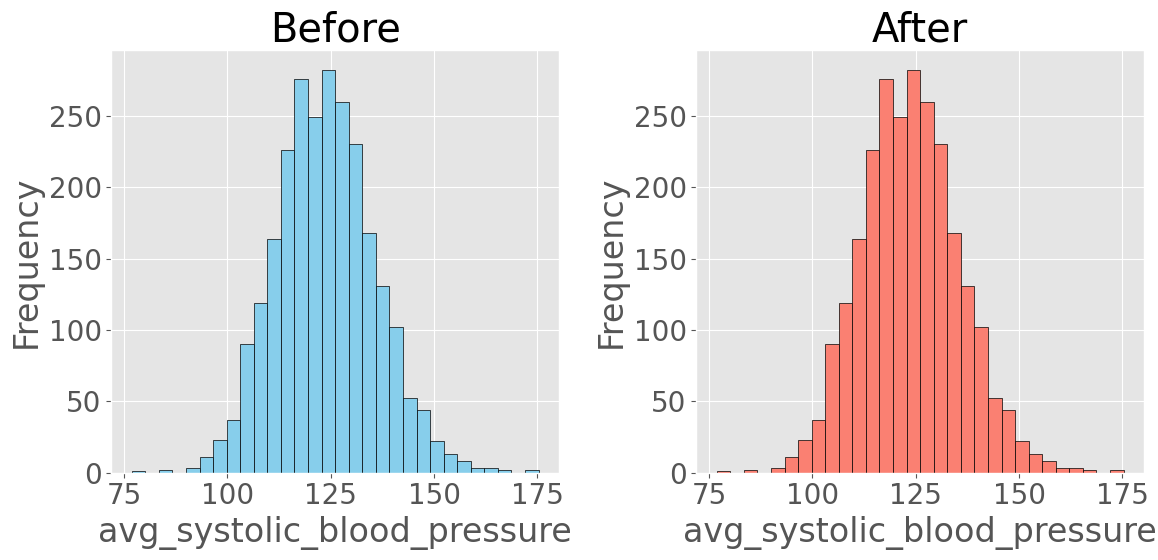

Summary Statistics Before Replacement for avg_systolic_blood_pressure:
count    2523.000000
mean      123.837213
std        11.861182
min        76.850000
25%       115.717767
50%       123.384979
75%       131.479607
max       175.300725
Name: avg_systolic_blood_pressure, dtype: float64

Summary Statistics After Replacement for avg_systolic_blood_pressure:
count    2523.000000
mean      123.837213
std        11.861182
min        76.850000
25%       115.717767
50%       123.384979
75%       131.479607
max       175.300725
Name: avg_systolic_blood_pressure, dtype: float64




<ipython-input-335-f1445ef8ccec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = filtered_df[column].apply(


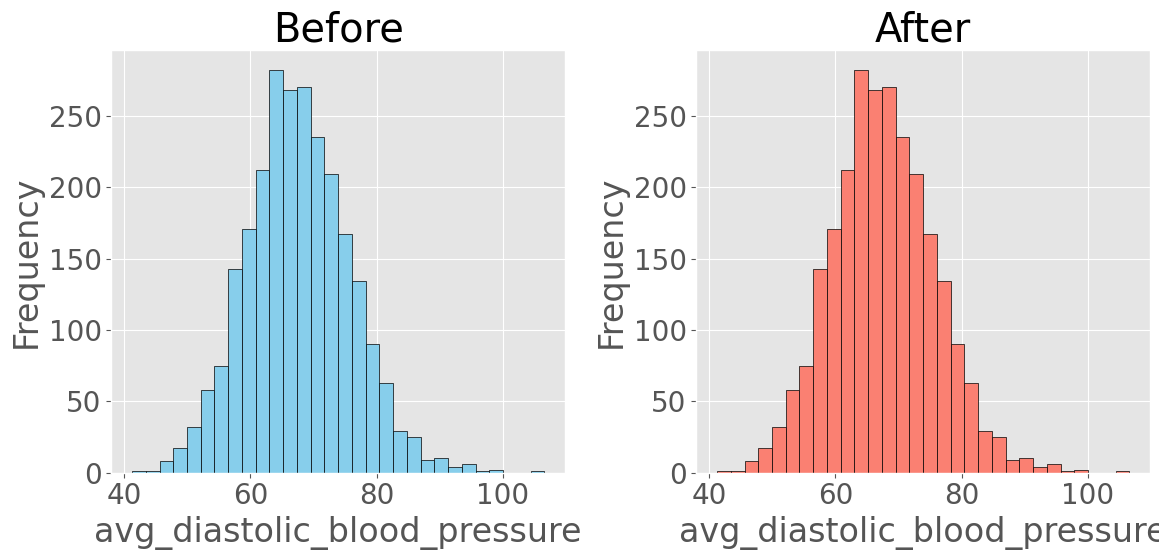

Summary Statistics Before Replacement for avg_diastolic_blood_pressure:
count    2523.000000
mean       67.633084
std         8.142441
min        41.242682
25%        62.226708
50%        67.350794
75%        73.030821
max       106.575758
Name: avg_diastolic_blood_pressure, dtype: float64

Summary Statistics After Replacement for avg_diastolic_blood_pressure:
count    2523.000000
mean       67.633084
std         8.142441
min        41.242682
25%        62.226708
50%        67.350794
75%        73.030821
max       106.575758
Name: avg_diastolic_blood_pressure, dtype: float64




In [335]:
filtered_df.drop(['avg_systolic_BP', 'avg_diastolic_BP', 'avg_dbp', 'avg_sbp','non_null_count'], axis=1, inplace=True)
print(filtered_df.shape)
filtered_df
filtered_df['dod'] = filtered_df['dod'].notna().astype(int)
mode_value = filtered_df['marital_status'].mode()[0]
filtered_df['marital_status'].fillna(mode_value, inplace=True)
filtered_df['marital_status'] = filtered_df['marital_status'].map({'WIDOWED': 0, 'MARRIED': 1, 'SINGLE': 2, 'DIVORCED': 3})
filtered_df['gender'] = filtered_df['gender'].map({'F': 0, 'M': 1})
unique_races = filtered_df['race'].unique()
def transform_race(race):
    if race.startswith('ASIAN'):
        return 'ASIAN'
    elif race.startswith('BLACK'):
        return 'BLACK'
    elif race.startswith('HISPANIC'):
        return 'HISPANIC'
    elif race.startswith('WHITE'):
        return 'WHITE'
    elif race in {'AMERICAN INDIAN/ALASKA NATIVE', 'SOUTH AMERICAN',
                   'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                   'MULTIPLE RACE/ETHNICITY', 'PORTUGUESE'}:
        return 'OTHER'
    elif race in {'UNABLE TO OBTAIN', 'UNKNOWN', 'PATIENT DECLINED TO ANSWER'}:
        return 'UNKNOWN'
    else:
        return race


filtered_df['race'] = filtered_df['race'].apply(transform_race)
filtered_df['race'] = filtered_df['race'].map({'WHITE': 0, 'BLACK': 1, 'HISPANIC': 2, 'OTHER': 3, 'UNKNOWN': 4, 'ASIAN': 5})

columns = [
    'average_apsiii', 'avg_ph', 'avg_body_weight', 'BMI', 'height_inches',
    'average_los_icu', 'avg_glucose', 'avg_heart_rate', 'avg_mbp',
    'avg_resp_rate', 'avg_spo2', 'avg_temperature',
    'avg_systolic_blood_pressure', 'avg_diastolic_blood_pressure'
]


for column in columns:

    column_before = filtered_df[column].copy()
    non_null_values = column_before.dropna()

    filtered_df[column] = filtered_df[column].apply(
        lambda x: float(np.random.choice(non_null_values)) + np.random.uniform(0.000001, 1) if pd.isna(x) else x
    )

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.hist(column_before.dropna(), bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Before')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(filtered_df[column], bins=30, color='salmon', edgecolor='black')
    plt.title(f'After')
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


    print(f"Summary Statistics Before Replacement for {column}:")
    print(column_before.describe())
    print(f"\nSummary Statistics After Replacement for {column}:")
    print(filtered_df[column].describe())
    print("\n" + "="*50 + "\n")

In [314]:
filtered_df

,subject_id,race,marital_status,age,average_apsiii,avg_charlson_comorbidity_index,gender,dod,avg_ph,avg_body_weight,BMI,height_inches,average_los_icu,avg_glucose,avg_heart_rate,avg_mbp,avg_resp_rate,avg_spo2,avg_temperature,avg_systolic_blood_pressure,avg_diastolic_blood_pressure
2,15465960,0,1,80,46.50,7.727273,1,0,7.328750,83.303347,27.712500,67.523750,0.909439,157.750000,76.039216,83.500000,20.568627,96.392157,36.613750000,126.535985,67.357955
3,12136799,0,1,58,55.00,5.285714,1,0,7.501111,67.134889,26.150526,63.025156,2.138831,212.860759,82.125000,84.970297,21.271845,97.970297,37.097419355,125.102216,67.068883
6,19005999,0,1,21,26.75,5.666667,1,0,7.368000,80.491234,22.976471,70.620833,1.080153,157.941176,96.735849,79.733333,16.000000,97.123711,36.930000000,117.840695,68.956261
7,13050816,1,3,61,46.00,2.763636,1,0,7.412500,59.474594,20.817910,66.166667,1.890556,104.833333,66.214286,87.121951,14.857143,96.500000,37.014545455,123.158378,82.245803
8,10213803,0,1,62,40.50,6.000000,1,0,7.400000,104.231952,31.979091,71.092157,2.456453,139.300000,95.510638,77.238462,19.465116,96.248062,37.083000000,115.580284,66.895023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,13652789,0,0,88,39.00,7.200000,1,1,7.384286,68.711124,23.125000,67.000000,1.543414,243.923077,67.486486,91.444444,17.216216,98.648649,36.581111111,137.711111,67.529630
9985,12796538,1,2,46,59.00,0.750000,0,0,7.391667,100.735805,31.283333,70.437500,7.177060,105.666667,123.777311,78.546610,26.280083,95.382979,37.547678571,125.169681,76.066305
9989,18908091,3,1,67,18.00,3.000000,1,0,7.357222,89.398447,37.200000,61.000000,1.937743,157.105263,75.413043,73.865079,15.744681,96.803922,37.309666667,123.178571,70.821429
9991,19555886,0,1,75,51.00,9.285714,1,1,7.365385,87.708446,28.860920,68.466667,2.323293,185.571429,68.517544,73.047170,18.944915,95.336207,36.958148148,140.386285,50.863157


In [336]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2523 entries, 1 to 9999
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   subject_id                      2523 non-null   Int64  
 1   race                            2523 non-null   int64  
 2   marital_status                  2523 non-null   int64  
 3   age                             2523 non-null   Int64  
 4   average_apsiii                  2523 non-null   float64
 5   avg_charlson_comorbidity_index  2523 non-null   float64
 6   gender                          2523 non-null   int64  
 7   dod                             2523 non-null   int64  
 8   avg_ph                          2523 non-null   float64
 9   avg_body_weight                 2523 non-null   float64
 10  BMI                             2523 non-null   float64
 11  height_inches                   2523 non-null   float64
 12  average_los_icu                 2523 no

In [337]:
file_path = 'generic_features_for_random_patient.csv'

filtered_df.to_csv(file_path, index=False)